<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Загрузка-модулей" data-toc-modified-id="Загрузка-модулей-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Загрузка модулей</a></span></li><li><span><a href="#Настройки" data-toc-modified-id="Настройки-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Настройки</a></span></li><li><span><a href="#Загрузка-данных" data-toc-modified-id="Загрузка-данных-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Загрузка данных</a></span></li><li><span><a href="#Вывод-этапа" data-toc-modified-id="Вывод-этапа-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Вывод этапа</a></span></li></ul></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span><ul class="toc-item"><li><span><a href="#Вывод-этапа" data-toc-modified-id="Вывод-этапа-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Вывод этапа</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Вывод-этапа" data-toc-modified-id="Вывод-этапа-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Вывод этапа</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Вывод-этапа" data-toc-modified-id="Вывод-этапа-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Вывод этапа</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Вывод</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
!pip install optuna
#!pip install optuna-dashboard
!pip install hyperopt
#!pip install sweetviz
#!pip3 install pandas-profiling==3.0.0

### Загрузка модулей

In [2]:
import time
import pandas as pd
import optuna
import plotly

#from pandas_profiling import ProfileReport
#import sweetviz as sv

from hyperopt import hp, fmin, tpe, Trials
from sklearn.metrics import mean_squared_error

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from scipy.stats import boxcox

from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn import svm
from sklearn.model_selection import TimeSeriesSplit

from catboost import CatBoostRegressor
import xgboost as xgb
from lightgbm import LGBMRegressor

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random

import warnings
warnings.filterwarnings("ignore")

### Настройки

In [3]:
RANDOM_STATE = 853973
state = np.random.RandomState(RANDOM_STATE)
# Цветовая палитра документа
cm = 'crest'
mec = 'gray'
alpha = 0.7
fontsize = 16
figsize_base = 5

def new_color(x='r'):
    '''Цвет графиков, по умолчанию случайный из заданной цветовой палитры. Принимает в качестве аргумента число, \
    соответствующее цвету в палитре.'''
    if x == 'r':
        return list(sns.color_palette(cm, 20)[random.randint(0,19)])
    return list(sns.color_palette(cm, 20)[x])
# Размеры

def figsize(width = 1, height=1):
    '''Задание размеров окна отрисовки.'''
    return (width*figsize_base, height*figsize_base)

# Отрисовка 
def plot_set(ax,title='',xlabel='',ylabel='',fontsize=fontsize,xrot=1,figsize=figsize(),theme = 'darkgrid'):
    '''Функция для отрисовки дополнительных параметров графиков. Подписьи осей и названия, размер шрифта и размер окна, 
    включение сетки.'''
    sns.set_style(theme)
    plt.xticks(rotation=45*int(xrot), fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    plt.title(title+'\n', fontsize=fontsize)
    plt.xlabel('\n'+xlabel, fontsize=fontsize)
    plt.ylabel(ylabel+'\n', fontsize=fontsize)
    plt.grid(visible=True, which='both')
    None
    
def mean_percent(x):
    '''Функция для форматирования значений. Округление до сотых и знак процента.'''
    try:
        return "{0:.2%}".format(x)
    except:
        return x

### Загрузка данных

In [4]:
try:
    df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
except:
    df = pd.read_csv('taxi.csv', index_col=[0], parse_dates=[0])

In [5]:
df.head(25)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21
2018-03-01 01:00:00,7
2018-03-01 01:10:00,5
2018-03-01 01:20:00,17


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [7]:
df.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


In [8]:
df.isna().mean().sort_values().apply(mean_percent)

num_orders    0.00%
dtype: object

In [9]:
#df.index.is_monotonic

### Вывод этапа

Изучен датафрейм `taxi.csv`:
- 1 столбец:
    - `num_orders` - число заказов за 10 минут
- 26496 строк
- Пропусков нет:
- Данные отсортированы по времени от 00:00 01.03.2018 до 23:50 31.08.2018

## Анализ

Выполним их ресемплирование по одному часу.

In [10]:
df = df.resample('1H').sum()

Посмотрим на распределение данных

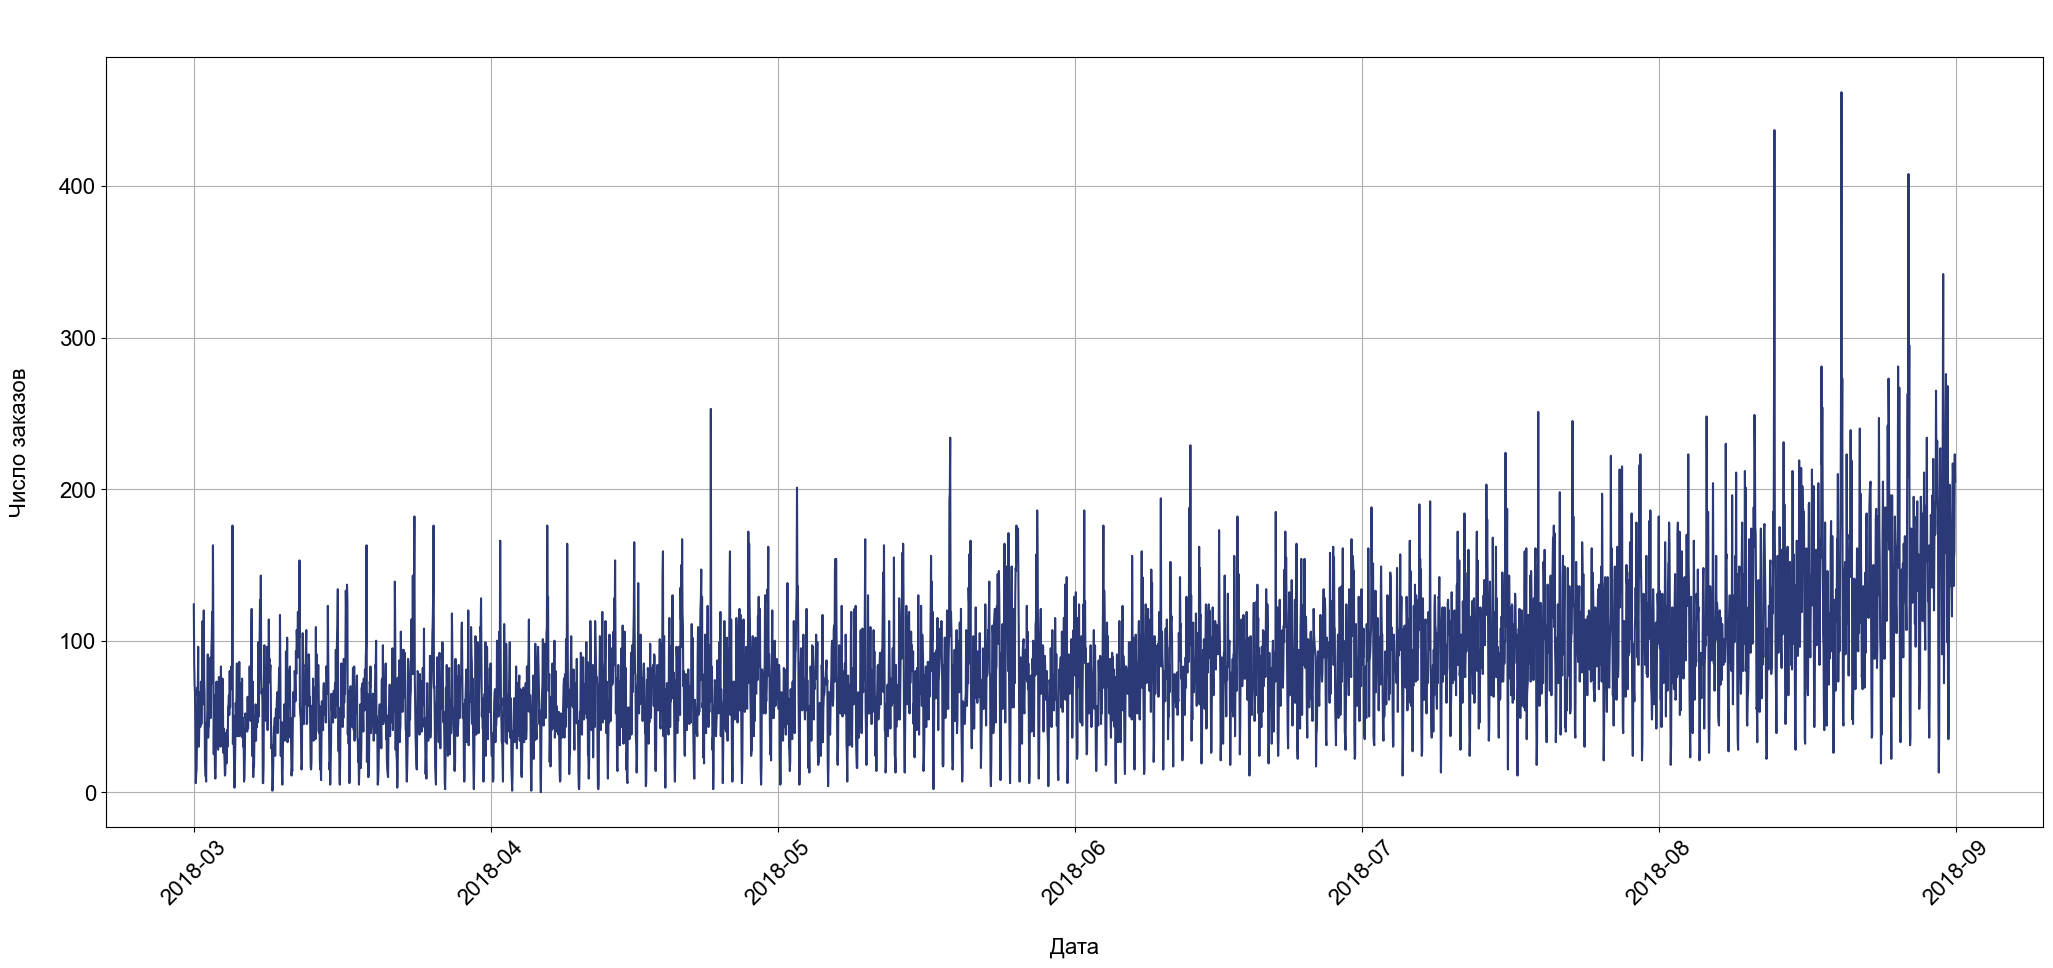

In [11]:
plt.figure(figsize=figsize(5,2))
ax = plt.plot(df,color=new_color())
plot_set(ax,xlabel='Дата',ylabel='Число заказов')

Рассмотрим тернды, сезонность, остаток декомпозиции заказа такси

In [12]:
decomposed = seasonal_decompose(df)

Тренд

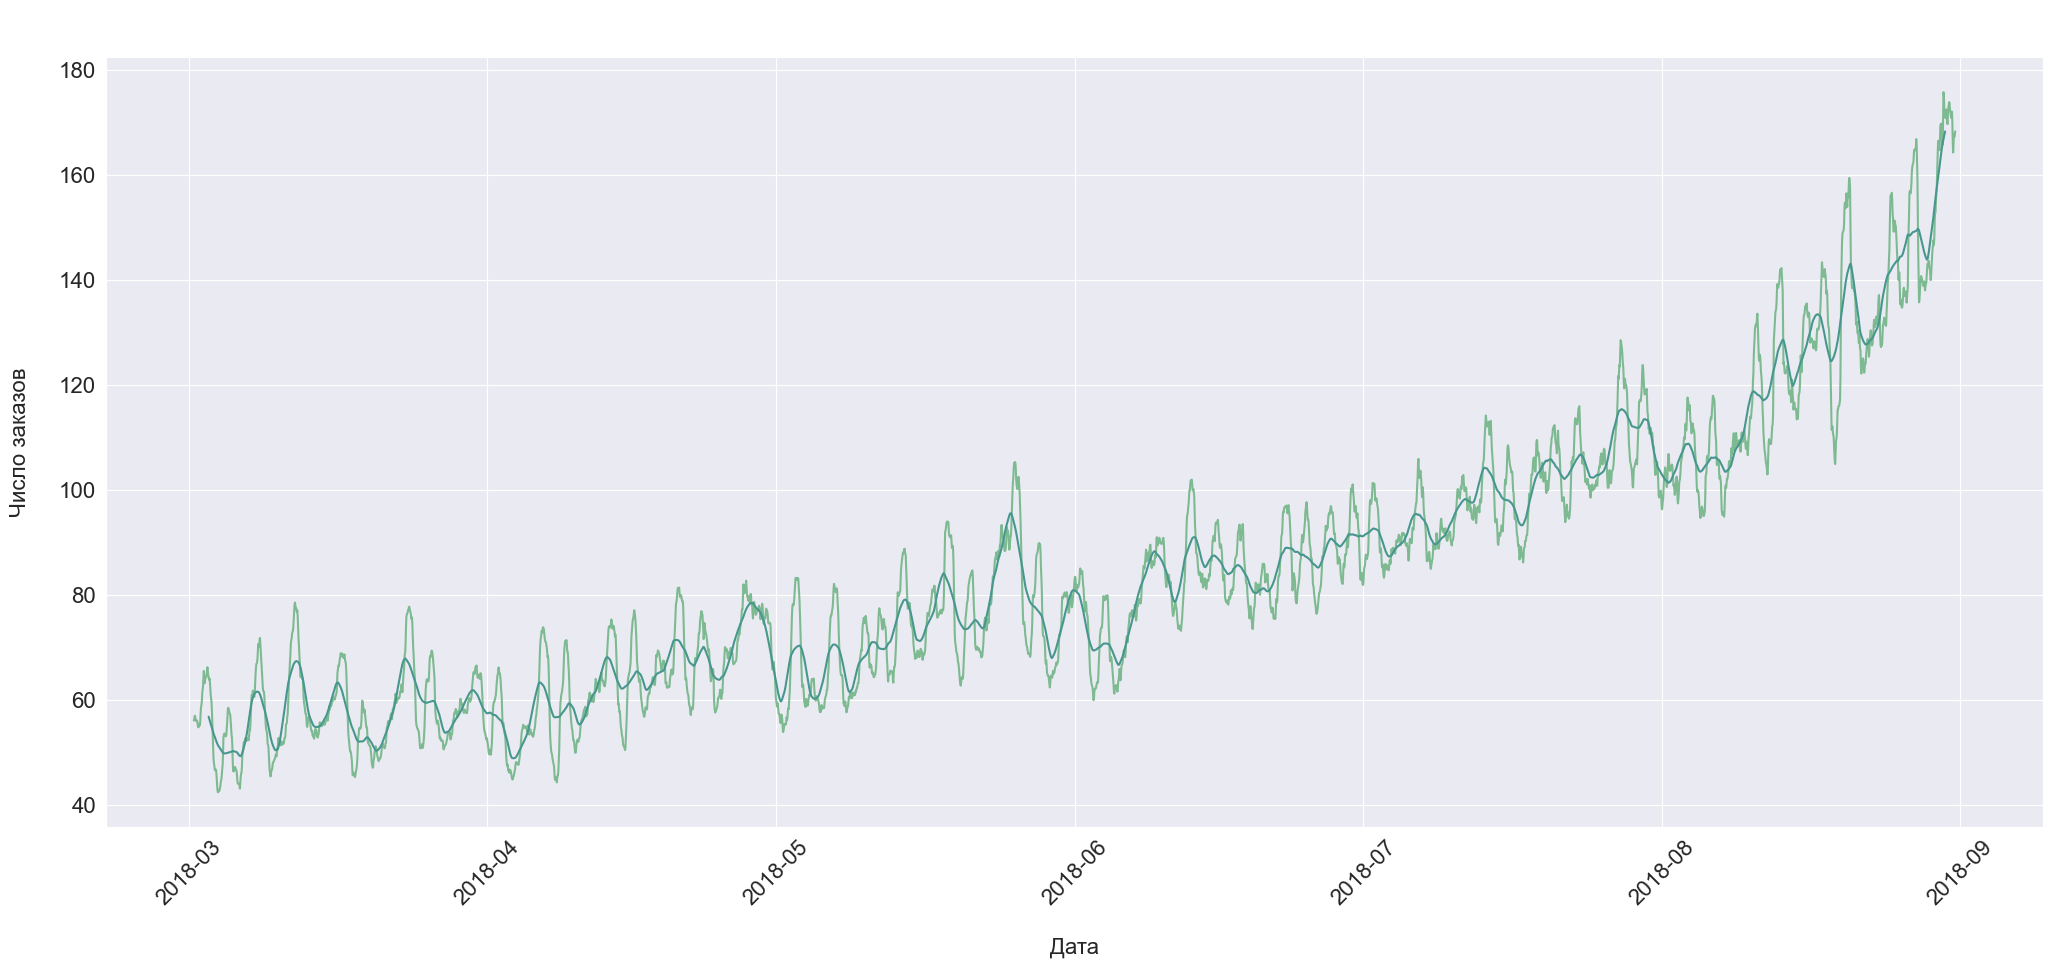

In [13]:
plt.figure(figsize=figsize(5,2))
ax = plt.plot(decomposed.trend,color=new_color())
plt.plot(decomposed.trend.shift(-25).rolling(50).mean(),color=new_color())
plot_set(ax,title='',xlabel='Дата',ylabel='Число заказов',xrot=True)

Виден рост тренда с течением времени

Сезонность.

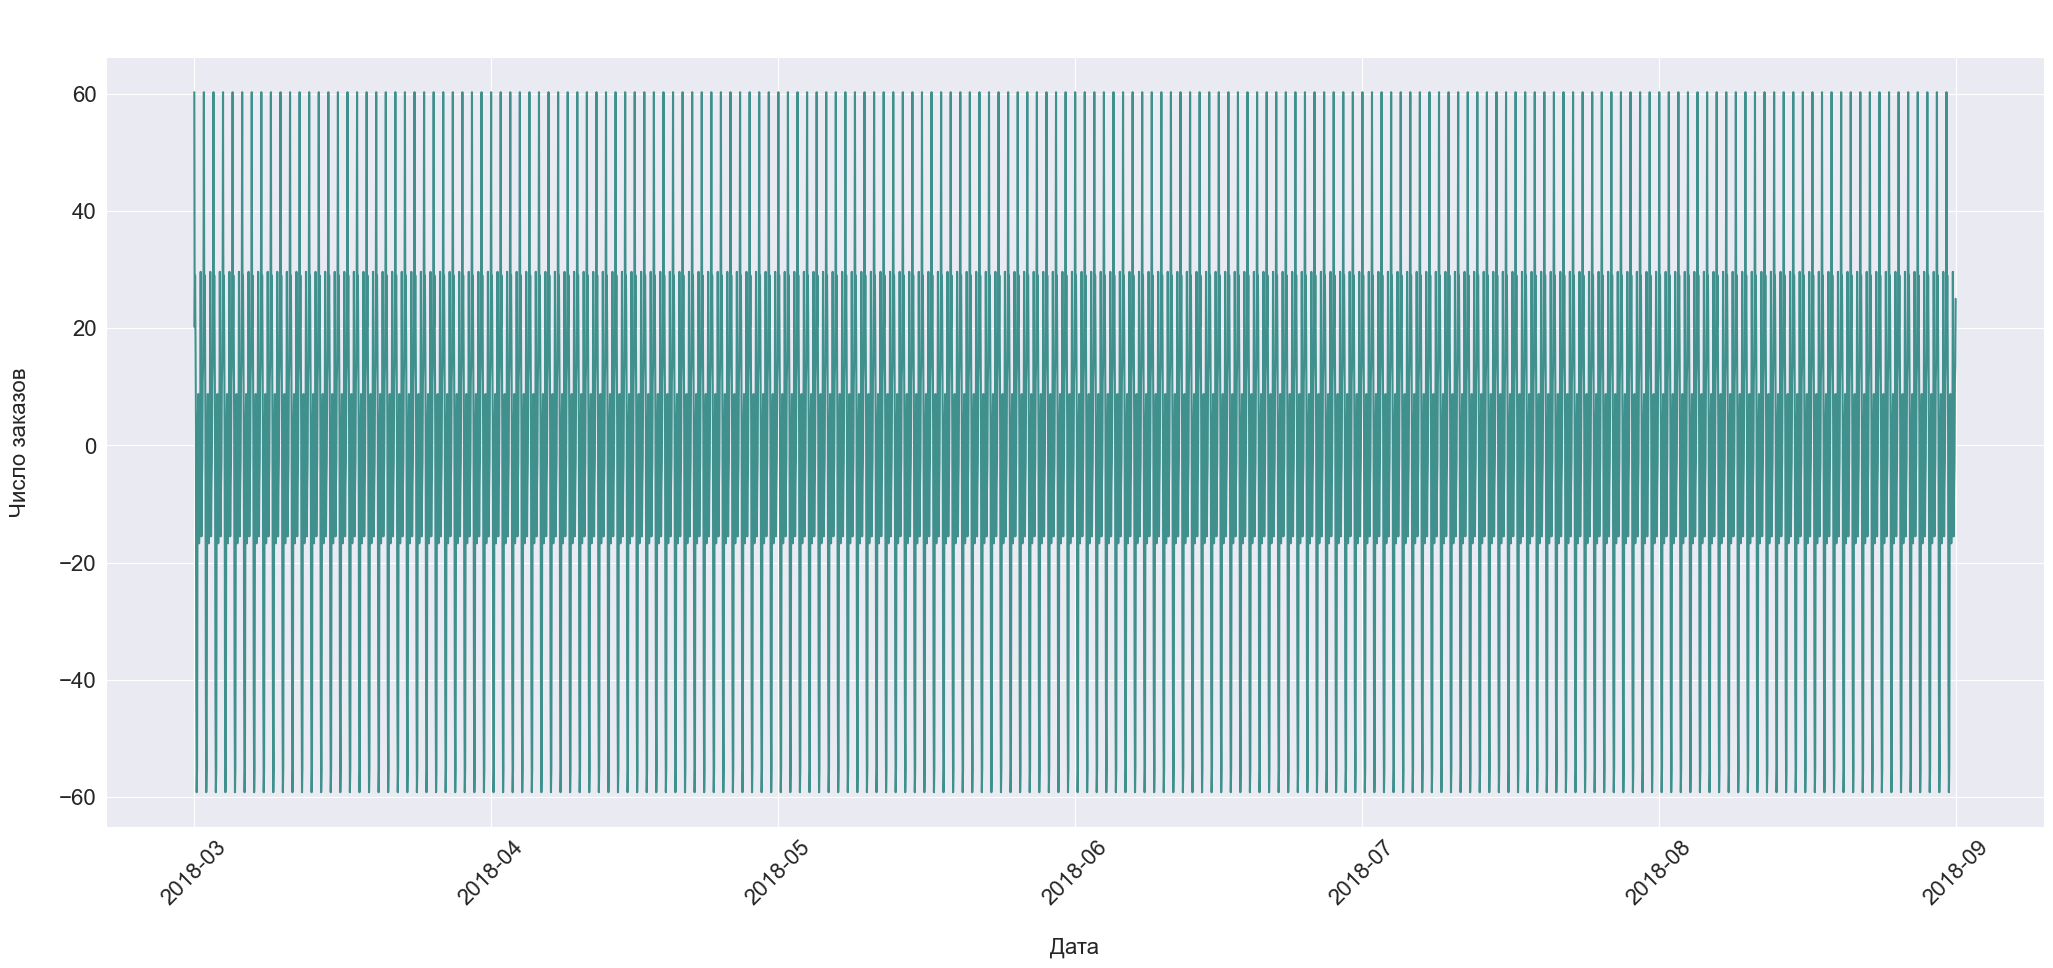

In [14]:
plt.figure(figsize=figsize(5,2))
ax = plt.plot(decomposed.seasonal,color=new_color())
plot_set(ax,title='',xlabel='Дата',ylabel='Число заказов',xrot=True)

Рассмотрим поближе

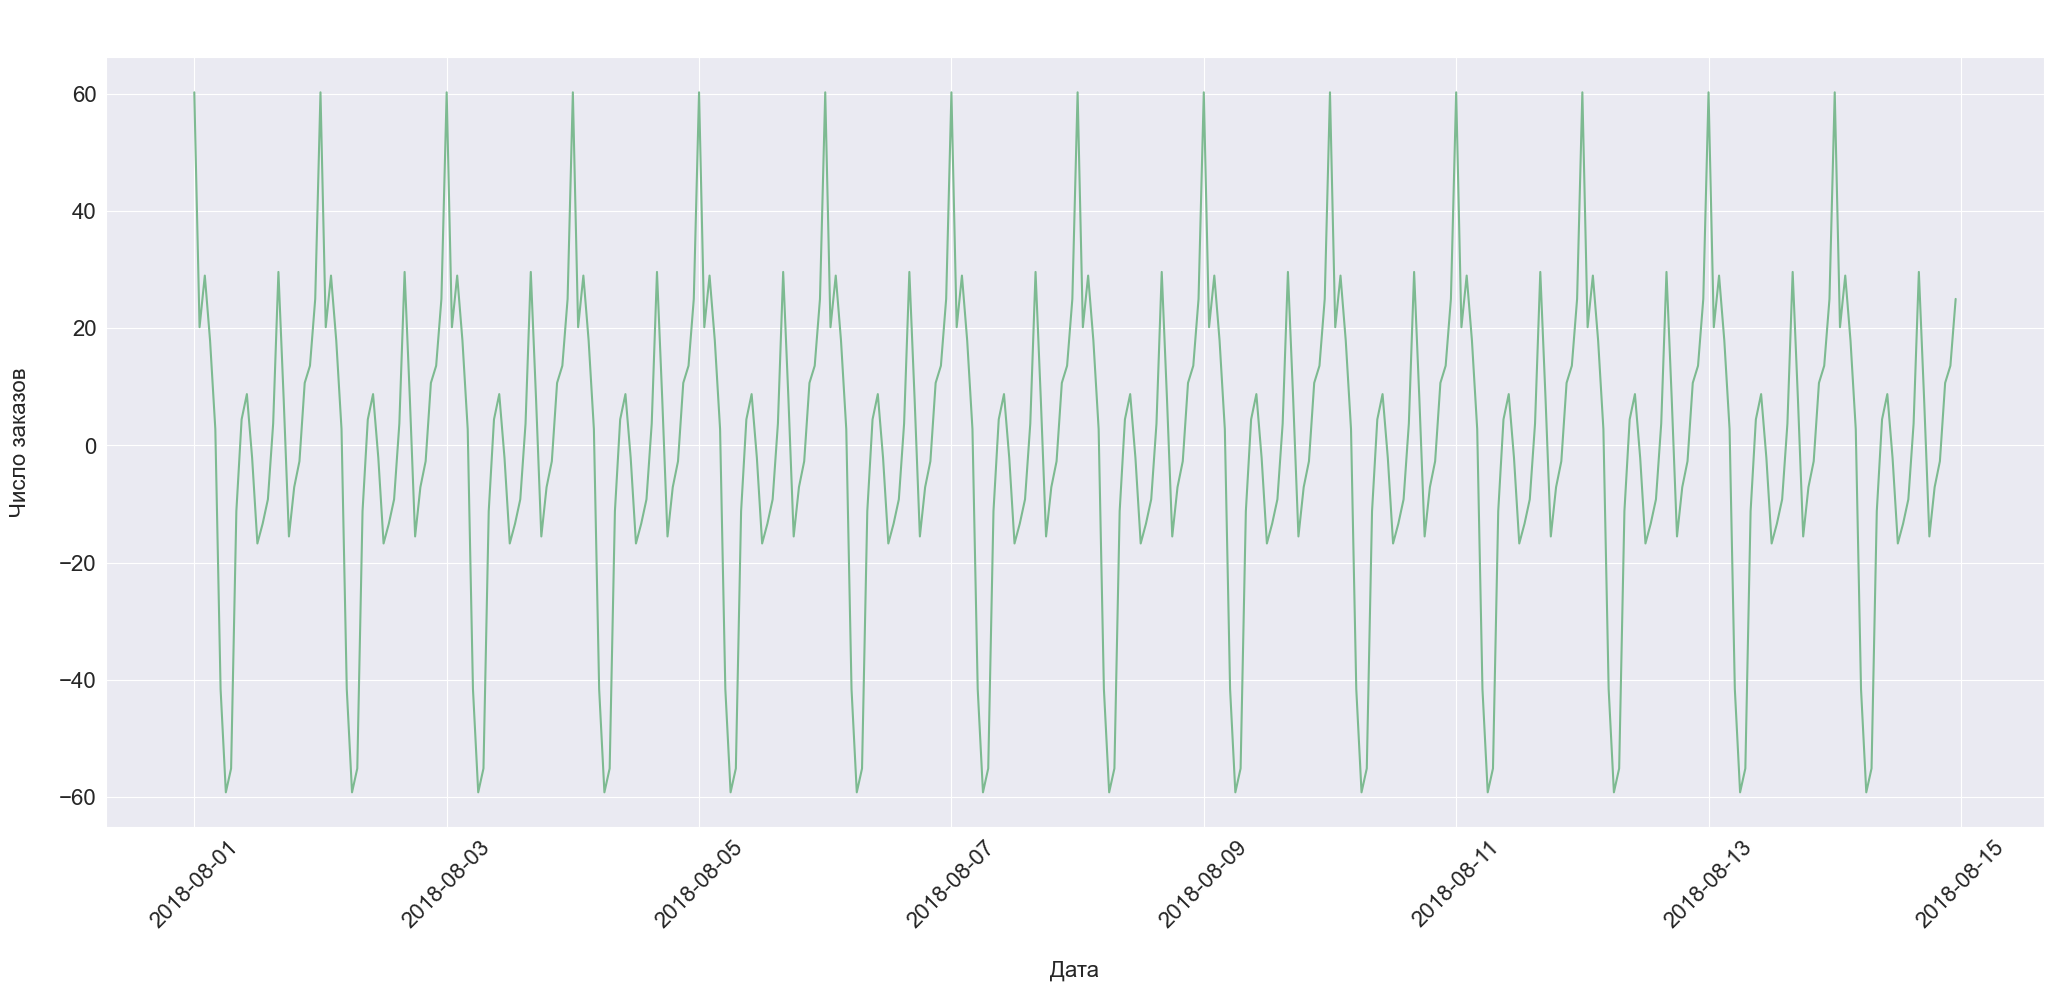

In [15]:
plt.figure(figsize=figsize(5,2))
ax = plt.plot(decomposed.seasonal['2018-08-01':'2018-08-14'],color=new_color())
plot_set(ax,title='',xlabel='Дата',ylabel='Число заказов',xrot=True)

Видно, что колебания периодические в течении дня

Остаток

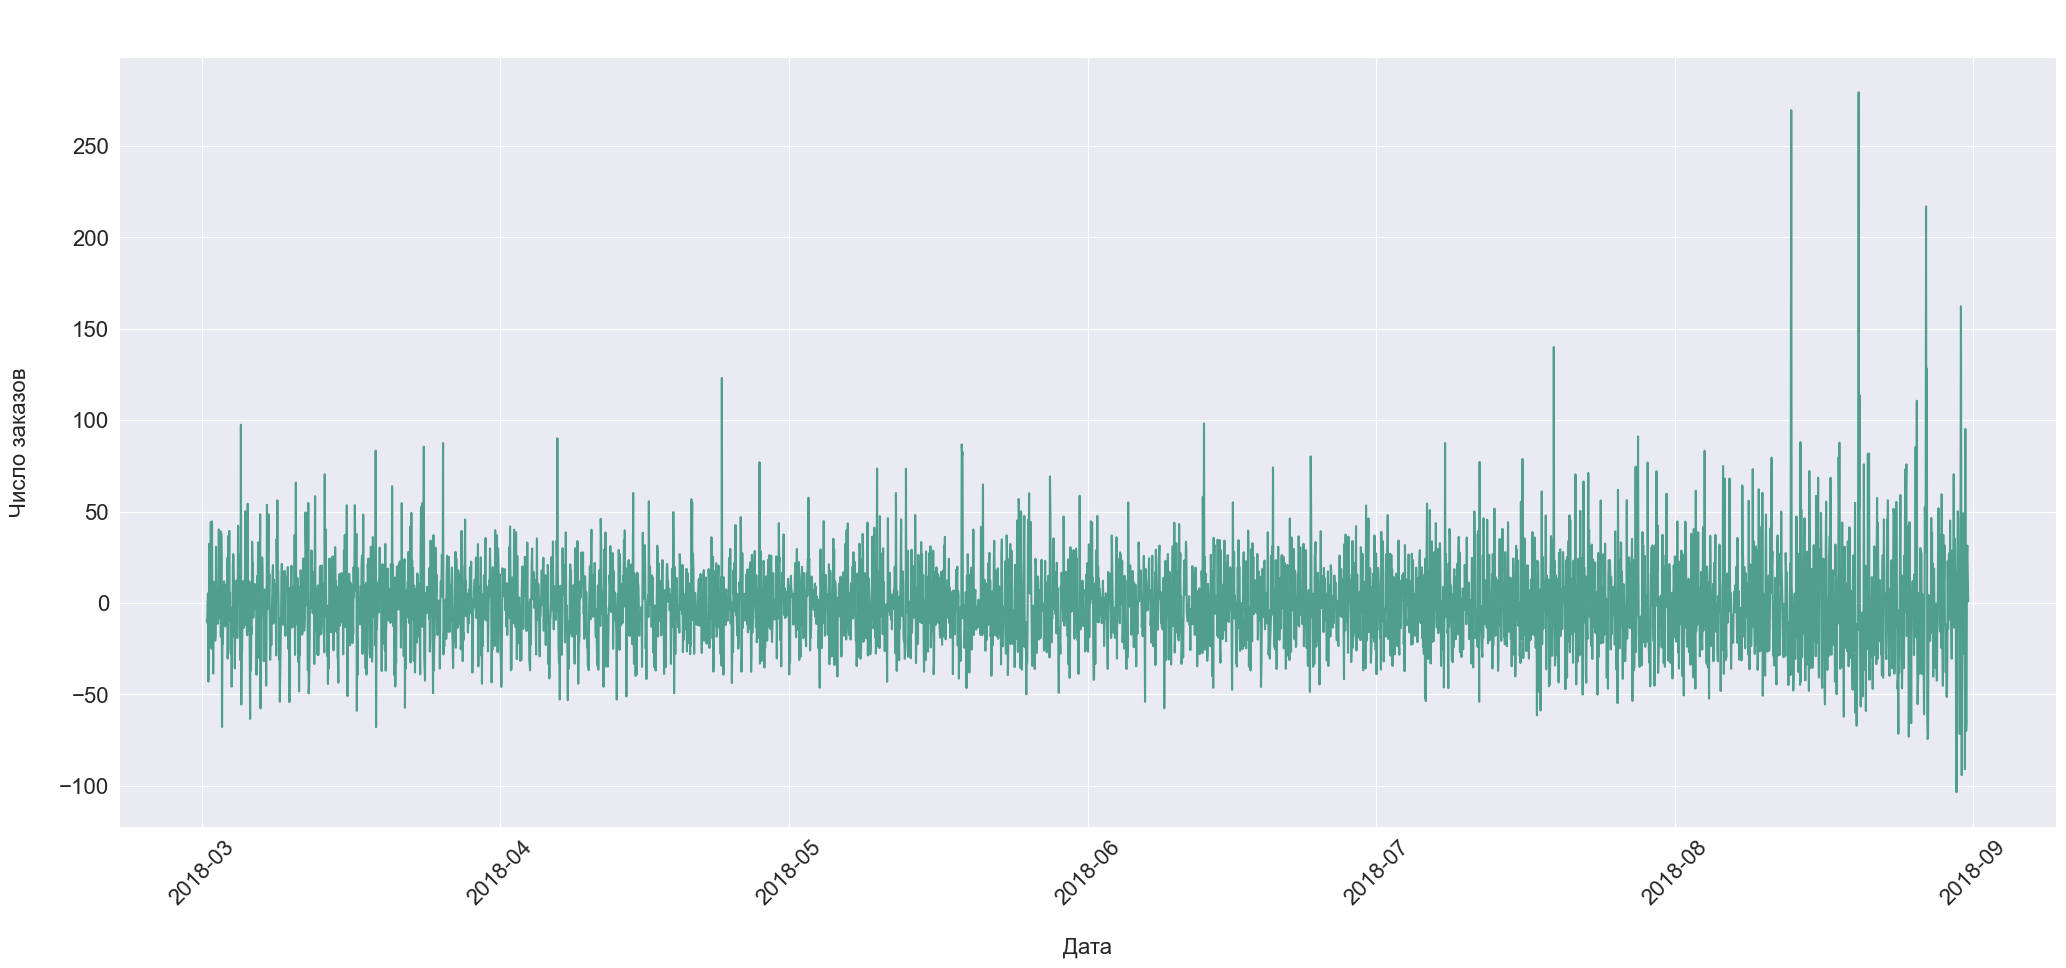

In [16]:
plt.figure(figsize=figsize(5,2))
ax = plt.plot(decomposed.resid,color=new_color())
plot_set(ax,title='',xlabel='Дата',ylabel='Число заказов',xrot=True)

In [17]:
p_value = adfuller(df['num_orders'])[1]
print('P =', p_value)
if p_value < 0.01:
    print('Нулевая гипотеза отвергается. Ряд стационарен по критерию Дики-Фуллера')
else:
    print('Нулевая гипотеза не отвергается. Ряд нестационарен по критерию Дики-Фуллера')

P = 0.0289400514026128
Нулевая гипотеза не отвергается. Ряд нестационарен по критерию Дики-Фуллера


In [18]:
df_shift = (df - df.shift()).dropna()

In [19]:
p_value = adfuller(df_shift['num_orders'])[1]
print('P =', p_value)
if p_value < 0.01:
    print('Нулевая гипотеза отвергается. Ряд стационарен по критерию Дики-Фуллера')
else:
    print('Нулевая гипотеза не отвергается. Ряд нестационарен по критерию Дики-Фуллера')

P = 1.0958776746509003e-28
Нулевая гипотеза отвергается. Ряд стационарен по критерию Дики-Фуллера


In [20]:
df[df['num_orders']==0].count()

num_orders    1
dtype: int64

In [21]:
df_boxcox, best_lambda = boxcox(df['num_orders']+0.00001)

In [22]:
p_value = adfuller(df_boxcox)[1]
print('P =', p_value)
if p_value < 0.01:
    print('Нулевая гипотеза отвергается. Ряд стационарен по критерию Дики-Фуллера')
else:
    print('Нулевая гипотеза не отвергается. Ряд нестационарен по критерию Дики-Фуллера')

P = 0.013733675457851402
Нулевая гипотеза не отвергается. Ряд нестационарен по критерию Дики-Фуллера


In [23]:
df_season = (df.T - decomposed.seasonal).dropna()

In [24]:
p_value = adfuller(df_season.T['num_orders'])[1]
print('P =', p_value)
if p_value < 0.01:
    print('Нулевая гипотеза отвергается. Ряд стационарен по критерию Дики-Фуллера')
else:
    print('Нулевая гипотеза не отвергается. Ряд нестационарен по критерию Дики-Фуллера')

P = 0.03033524804846971
Нулевая гипотеза не отвергается. Ряд нестационарен по критерию Дики-Фуллера


### Вывод этапа

- Тренд в общем растет, то есть количество заказов и пользователей растет.
- Распределение не однородно в течение дня.
- Временной ряд в не является стационарным, так как подвержен тренду, который меняется во времени.

## Обучение

Напишем функцию для создания признаков. Разберём каждый тип признаков:
1. Календарные признаки
2. «Отстающие значения»
3. Скользящее среднее

In [25]:
def make_features(data, max_lag, rolling_mean_size):
    # Формирование календарных признаков
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    #data['month'] = data.index.month
    
    # Формирование отстающих признаков
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
        
    # Добавление признака скользящего среднего
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    return data

Выберем `max_lag` равным 1, `rolling_mean_size` равным 24 поскольку это период сезонных колебаний.

In [26]:
df_learning = df.copy()
df_learning = make_features(df_learning,1,24).dropna()

Разделим выборку на обучающую и тестовую.

In [27]:
X_train, X_test, Y_train, Y_test = train_test_split(df_learning.drop(['num_orders'], axis=1),
                                                    df_learning['num_orders'], shuffle=False, test_size=0.1)

In [28]:
print(X_train.shape)
print(X_test.shape)

(3952, 4)
(440, 4)


In [29]:
X_train, X_valid, Y_train, Y_valid = train_test_split(X_train, Y_train, 
                                                      shuffle=False, test_size=0.05)

In [30]:
print(X_train.shape)
print(X_valid.shape)

(3754, 4)
(198, 4)


Добавим ещё одну выборку для визуализации предсказаний. Назовём её валидационной, хотя по сути она будет только вспомогательной, поскольку расчёт метрики будет проводиться с помощью метода кросс-валидации

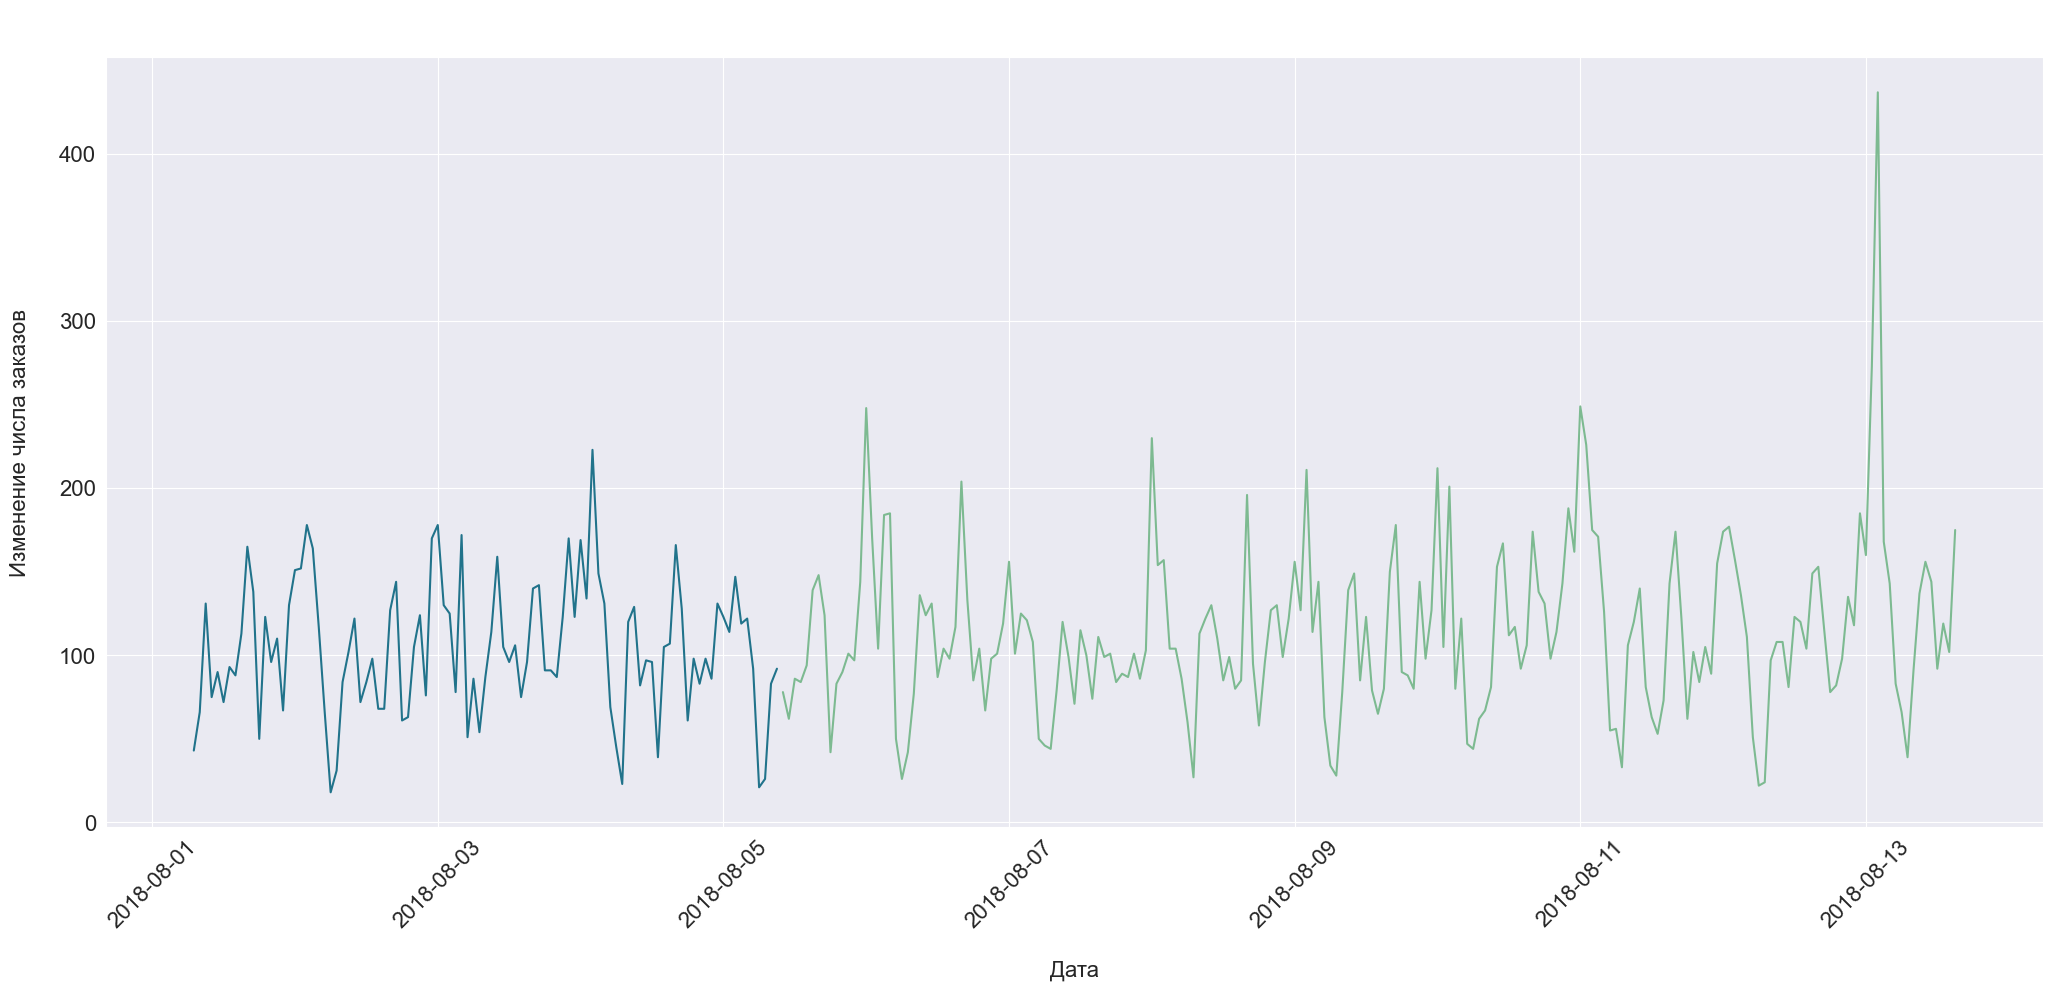

In [31]:
plt.figure(figsize=figsize(5,2))
ax = plt.plot(Y_valid,color=new_color(2))
plt.plot(Y_train.iloc[-len(Y_valid)//2:],color=new_color(12))
plot_set(ax,title='',xlabel='Дата',ylabel='Изменение числа заказов',xrot=True)

Слева кусочек обучающей выборки, справа валидационная.

Посмотрим на метрики константного метода

In [32]:
pred_median = pd.DataFrame(np.ones(Y_valid.shape) * Y_valid.median(), index = Y_valid.index)

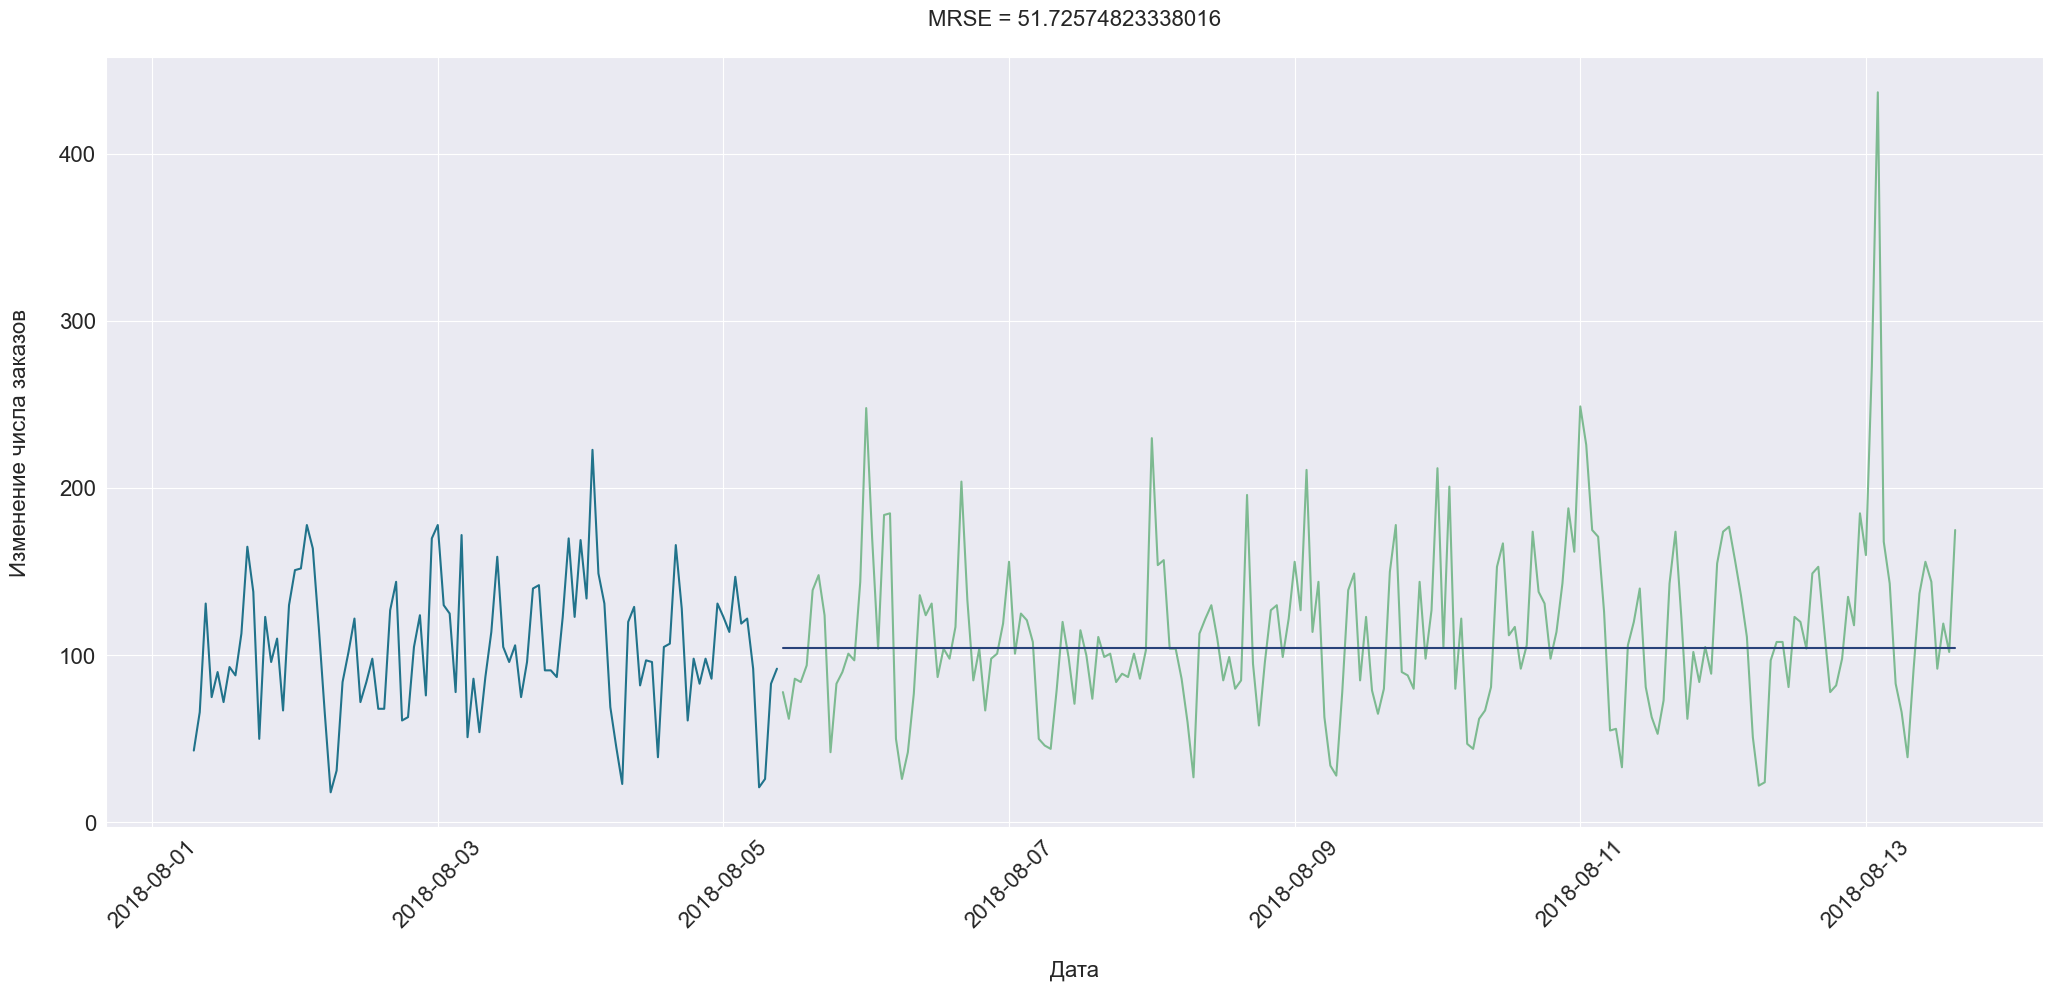

In [33]:
plt.figure(figsize=figsize(5,2))
ax = plt.plot(Y_valid,color=new_color(2))
plt.plot(Y_train.iloc[-len(Y_valid)//2:],color=new_color(12))
plt.plot(pred_median,color=new_color(18))
plot_set(ax,title = f'MRSE = {mean_squared_error(pred_median,Y_valid)**0.5}',xlabel='Дата',ylabel='Изменение числа заказов',xrot=True)

При кросс валидации зададим разбиение на 3 части

In [34]:
cv_splits = 3
tss = TimeSeriesSplit(n_splits=cv_splits)

Рассмотрим модель линейной регрессии

In [35]:
model = LinearRegression()
score_linear = -cross_val_score(model, X_train, Y_train, cv = tss, scoring='neg_root_mean_squared_error', n_jobs = 2).mean()
score_linear

31.691173724838137

In [36]:
model.fit(X_train, Y_train)
Y_pred = pd.DataFrame(model.predict(X_valid),index=Y_valid.index)

Визуализируем результаты

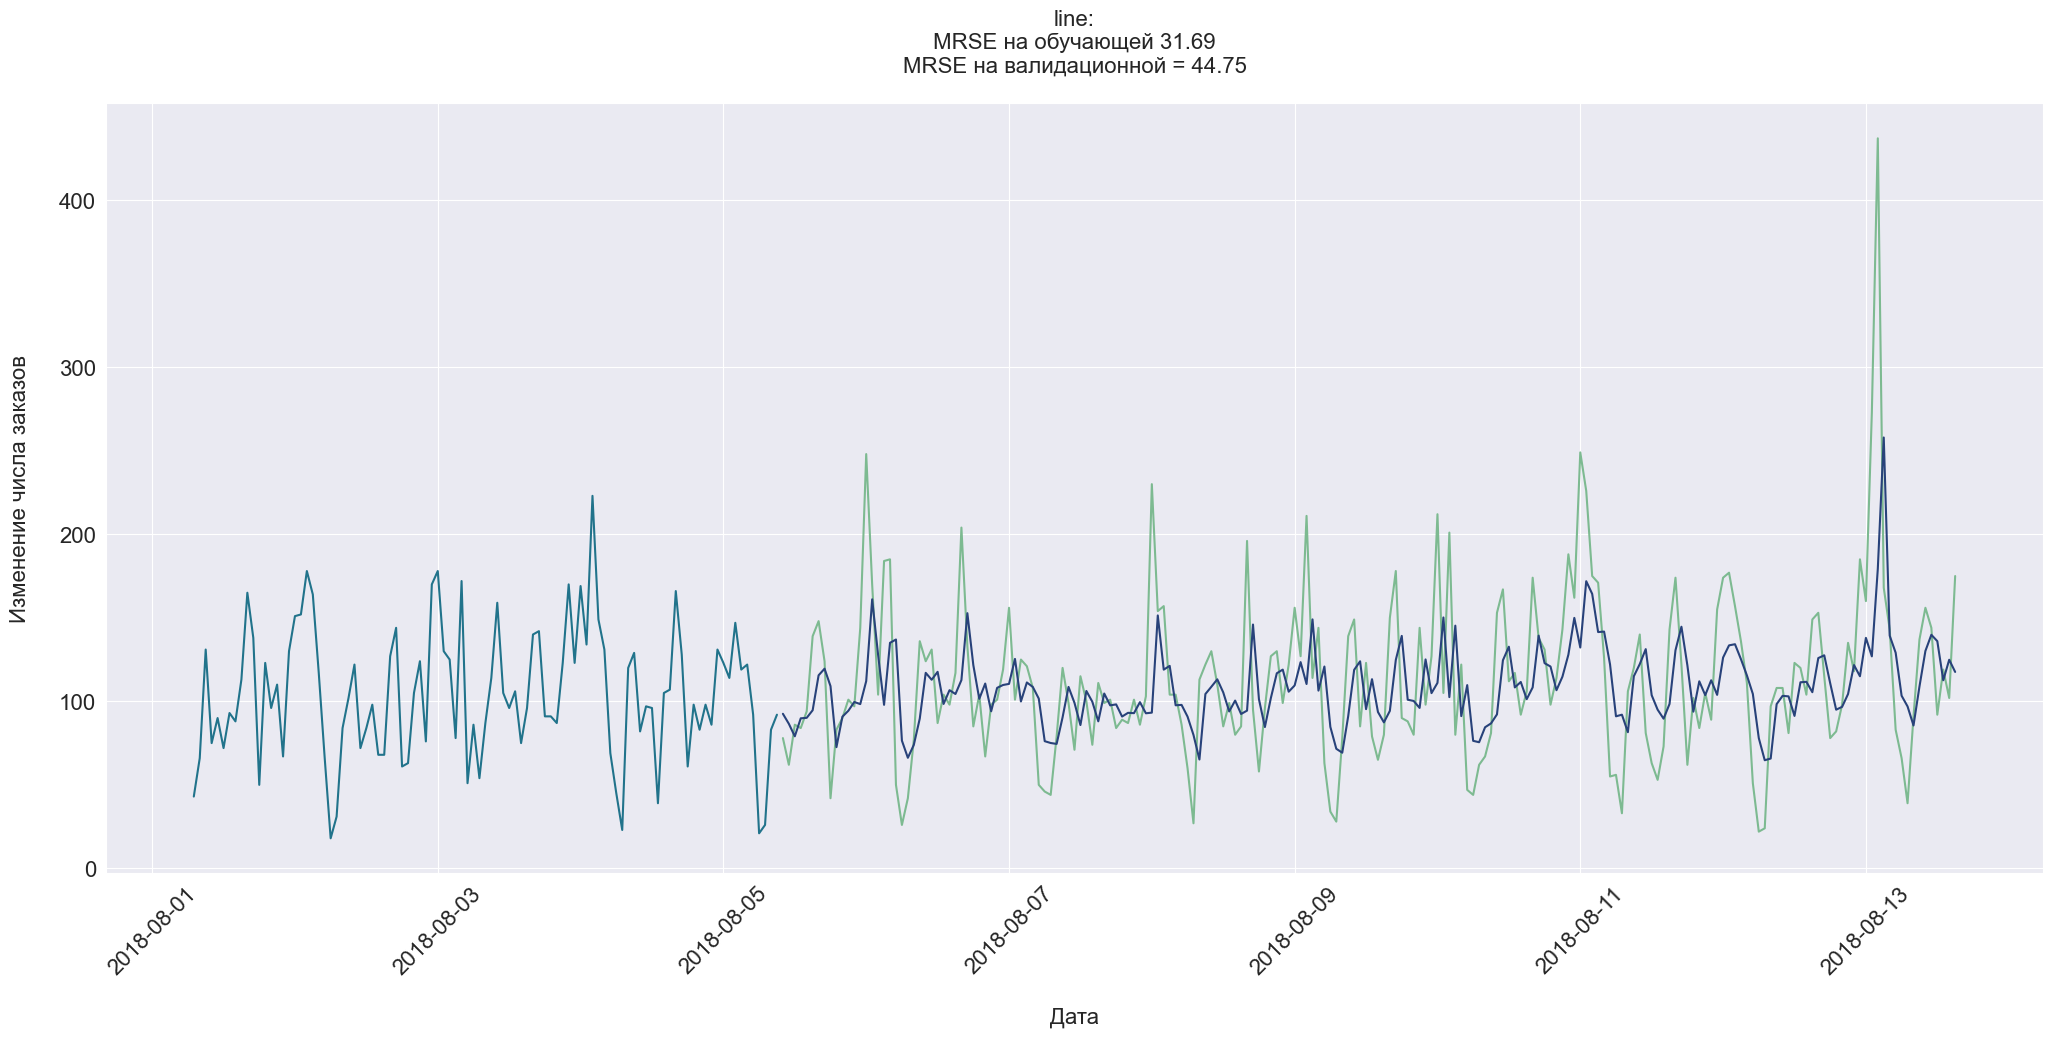

In [37]:
plt.figure(figsize=figsize(5,2))
ax = plt.plot(Y_valid,color=new_color(2))
plt.plot(Y_train.iloc[-len(Y_valid)//2:],color=new_color(12))
plt.plot(Y_pred,color=new_color(18))
score_linear_valid = mean_squared_error(Y_pred,Y_valid)**0.5

plot_set(ax,title = f'line:\n MRSE на обучающей {score_linear:.2f} \nMRSE на валидационной = {mean_squared_error(Y_pred, Y_valid)**0.5:.2f}',xlabel='Дата',ylabel='Изменение числа заказов',xrot=True)


Какие то закономерности явно угадываются. Но далеко от идеала.

Зададим функцию для поиска оптимальных гипперпараметров моделей. В качестве моделей будем использовать:
- `DecisionTreeRegressor`
- `RandomForestRegressor`
- `XGBRegressor`
- `LGBMRegressor`

Изначально планировалось рассмотреть ещё и `cat_boost`, он показал хорошие результаты, но очень медленно работал.

In [38]:
def objective(trial,features=X_train,target=Y_train):
    if model_type == 'tree':
        param = {
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 2, 7),
            'max_depth': trial.suggest_int('max_depth', 1, 100),
        }

        # создаем модель
        model = DecisionTreeRegressor(**param, random_state=RANDOM_STATE)
        
    elif model_type == 'random_forest':
        param = {
            'n_estimators': trial.suggest_int('n_estimators', 50, 200),
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 5),
            'max_depth': trial.suggest_int('max_depth', 1, 60),
        }

        # создаем модель
        model = RandomForestRegressor(**param, random_state=RANDOM_STATE)
        
    elif model_type == 'svm':
        param = {
            'kernel': trial.suggest_categorical('kernel', ['rbf']),
            'C': trial.suggest_float('C', 1e-2, 1e2,log=True),
            'gamma': trial.suggest_float('gamma', 1e-3, 1e3,log=True)
        }

        # создаем модель
        model = svm.SVR(**param)
        
    elif model_type == 'xg_boost':
        param = {
            #'tree_method':'gpu_hist',  # this parameter means using the GPU when training our model to speedup the training process
            'lambda': trial.suggest_float('lambda', 1e-3, 10.0,log=True),
            #'alpha': trial.suggest_float('alpha', 1e-3, 10.0,log=True),
            #'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
            #'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
            #'learning_rate': trial.suggest_categorical('learning_rate', [0.008,0.01,0.018, 0.02]),
            'n_estimators': trial.suggest_int('n_estimators', 50, 150),
            'max_depth': trial.suggest_int('max_depth', 2, 10),
            #'min_child_weight': trial.suggest_int('min_child_weight', 1, 300),
        }
        model = xgb.XGBRegressor(**param, random_state=RANDOM_STATE)
        
    elif model_type == 'cat_boost':
        param = {
            #'loss_function': 'RMSE',
            'verbose' : False,
            #'task_type': 'GPU',
            #'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-3, 10.0,log=True),
            #'max_bin': trial.suggest_int('max_bin', 200, 400),
            #'rsm': trial.suggest_uniform('rsm', 0.3, 1.0),
            #'subsample': trial.suggest_float('bagging_fraction', 0.4, 1.0),
            'learning_rate': trial.suggest_float('learning_rate', 0.006, 0.018),
            'n_estimators': trial.suggest_int('n_estimators', 800, 1200),
            'max_depth': trial.suggest_int('max_depth', 5, 16),
            #'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 300),
        }
        model = CatBoostRegressor(**param, random_state=RANDOM_STATE)
    
    elif model_type == 'light_GBM':
        
        param = {
            'num_leaves': trial.suggest_int('num_leaves', 20, 150), 
            'learning_rate': trial.suggest_float('learning_rate', .05, .5),
            'n_estimators': trial.suggest_int('n_estimators', 50, 150)
        }
            
        model = LGBMRegressor(**param, random_state=RANDOM_STATE)
    
    
    score = cross_val_score(model, features, target, cv = tss, scoring='neg_root_mean_squared_error', n_jobs = 2).mean()
    
    return -score

In [39]:
def search_best_params(model_type,n_trials):
    sampler = optuna.samplers.TPESampler(seed=RANDOM_STATE)
    optuna.logging.set_verbosity(optuna.logging.WARNING)
    study = optuna.create_study(study_name=model_type,
                                       direction="minimize",
                                       sampler=sampler)
    # ищем лучшую комбинацию гиперпараметров n_trials раз
    study.optimize(objective, n_trials=n_trials)

    
    return study.best_params, study.best_value

In [40]:
def model_visualization(model_type, n_trials=10):
    best_params, best_value = search_best_params(model_type=model_type,n_trials=n_trials)
    if model_type == 'tree':
        model = DecisionTreeRegressor(**best_params, random_state=RANDOM_STATE)
    elif model_type == 'random_forest':
        model = RandomForestRegressor(**best_params, random_state=RANDOM_STATE)
    elif model_type == 'xg_boost':
        model = xgb.XGBRegressor(**best_params, random_state=RANDOM_STATE)
    elif model_type == 'cat_boost':
        model = CatBoostRegressor(**best_params, random_state=RANDOM_STATE,verbose=False)
    elif model_type == 'light_GBM':
        model = LGBMRegressor(**best_params, random_state=RANDOM_STATE,verbose=0)
        
    model.fit(X_train, Y_train)
    Y_pred = pd.DataFrame(model.predict(X_valid),index=Y_valid.index)
    
    plt.figure(figsize=figsize(5,2))
    ax = plt.plot(Y_valid,color=new_color(2))
    plt.plot(Y_train.iloc[-len(Y_valid)//2:],color=new_color(12))
    plt.plot(Y_pred,color=new_color(18))
    plot_set(ax,title = model_type+f':\n MRSE на обучающей {best_value:.2f} \nMRSE на валидационной = {mean_squared_error(Y_pred, Y_valid)**0.5:.2f}',xlabel='Дата',ylabel='Изменение числа заказов',xrot=True)
    
    plt.axes([.08, .55, .32, .3]) 
    feature_importances = pd.DataFrame(model.feature_importances_,index = X_train.columns, columns = ['feature'])
    ax1 = sns.barplot(data=feature_importances, x=feature_importances.index, y='feature', palette=cm)
    plot_set(ax1,xrot=2) 
    plt.tight_layout()
    return best_params, best_value, mean_squared_error(Y_pred, Y_valid)**0.5

Будем сохранять параметры лучших моделей.

In [41]:
best_params = {
    'line': [],
    'tree': [],
    'random_forest': [],
    'xg_boost': [],
    'light_GBM': [],
}

MRSEs = {
    'line': score_linear,
    'tree': [],
    'random_forest': [],
    'xg_boost': [],
    'light_GBM': [],
}

valid_MRSEs = {
    'line': score_linear_valid,
    'tree': [],
    'random_forest': [],
    'xg_boost': [],
    'light_GBM': [],
}

Обучим модель дерева и визуализируем данные. Добавим информацию о важности признаков.

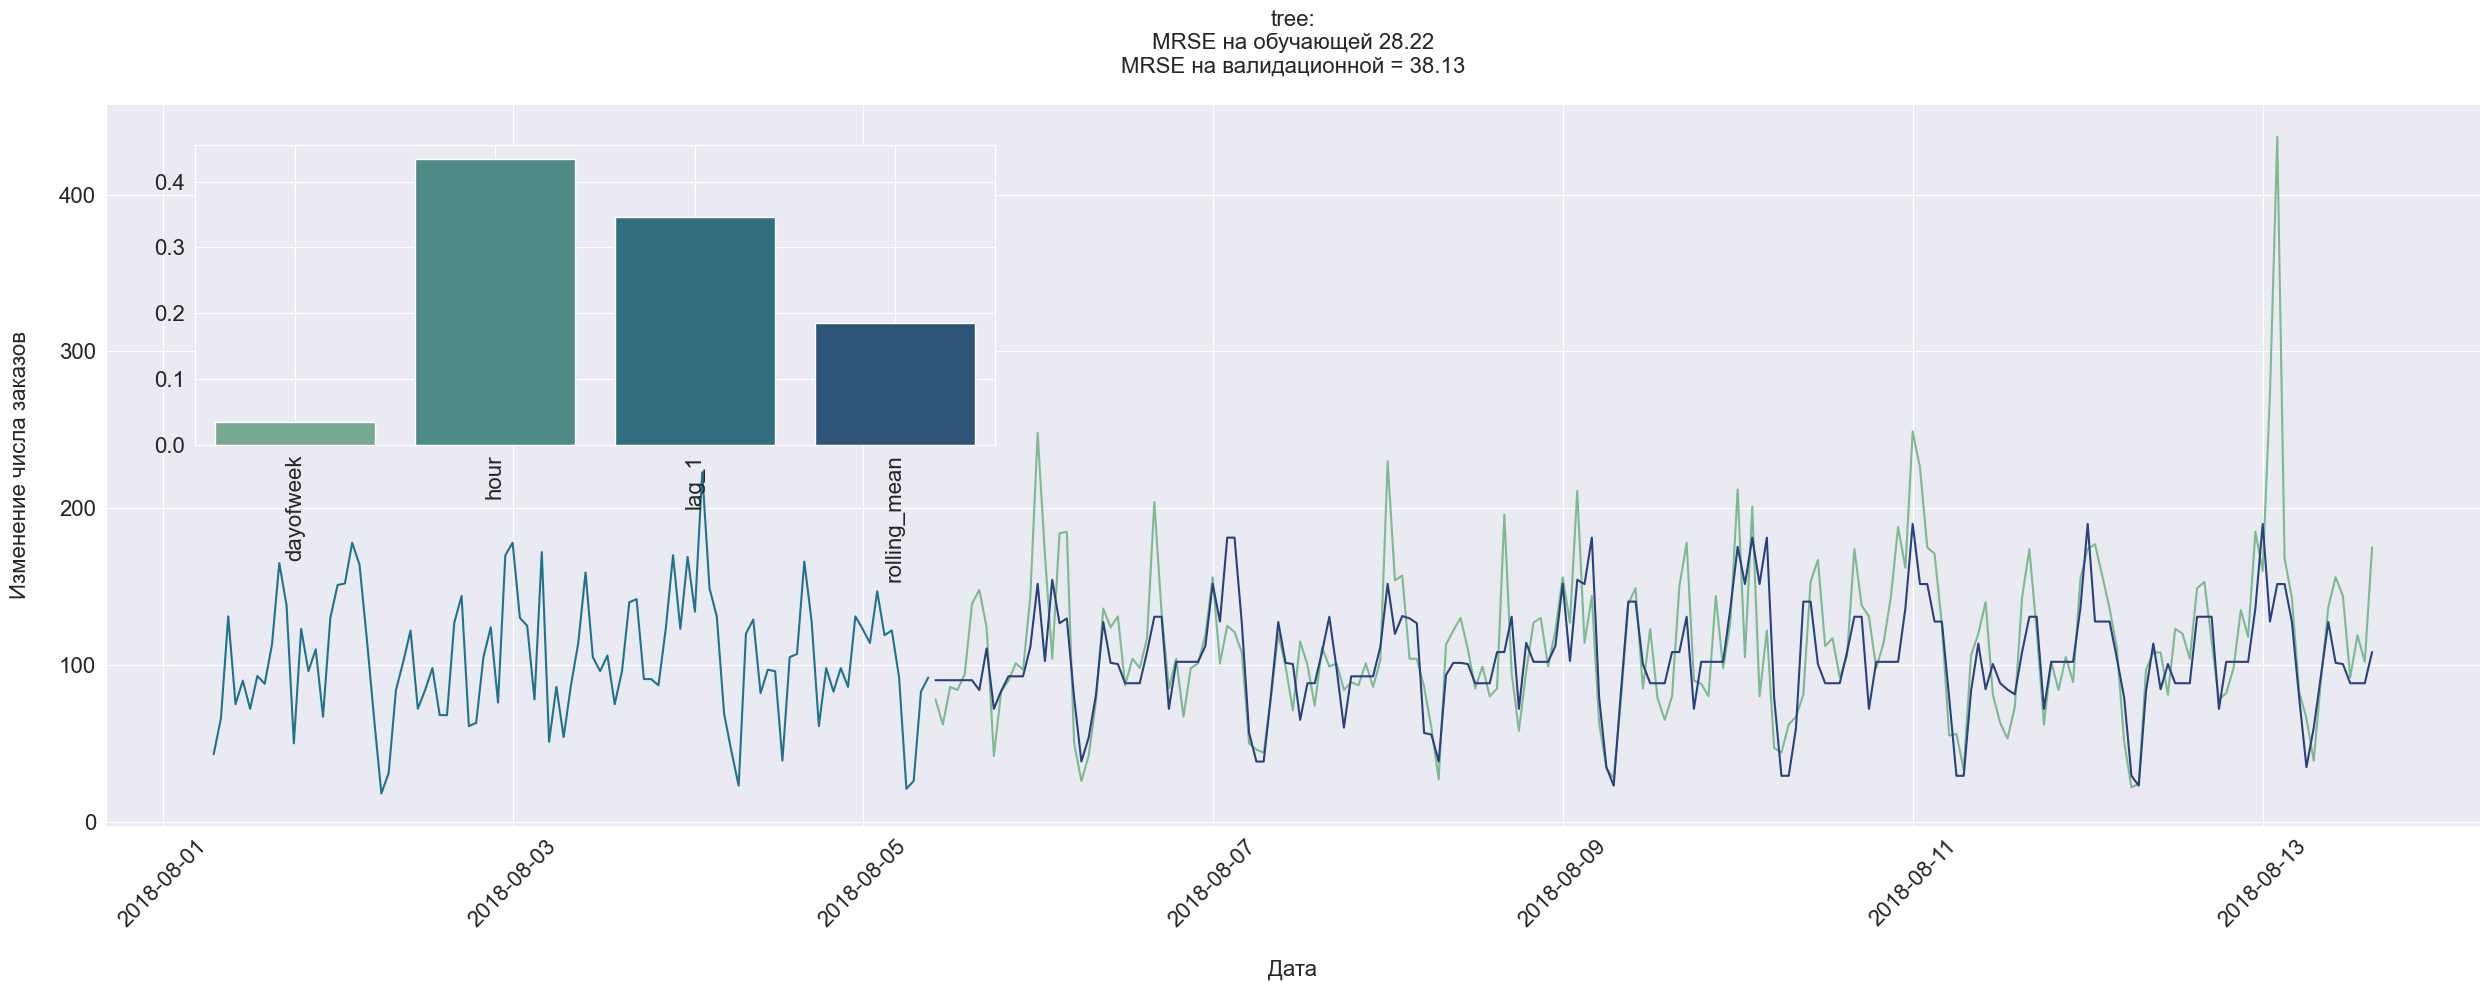

In [42]:
model_type = 'tree'
best_params[model_type], MRSEs[model_type], valid_MRSEs[model_type] = model_visualization(model_type=model_type, n_trials=30)

Хуже линейной на кросс валидации, но лучше на валидационной. Важные признаки `hour` и `lag_1`, что выглядит логичным.

Повторим для случайного леса.

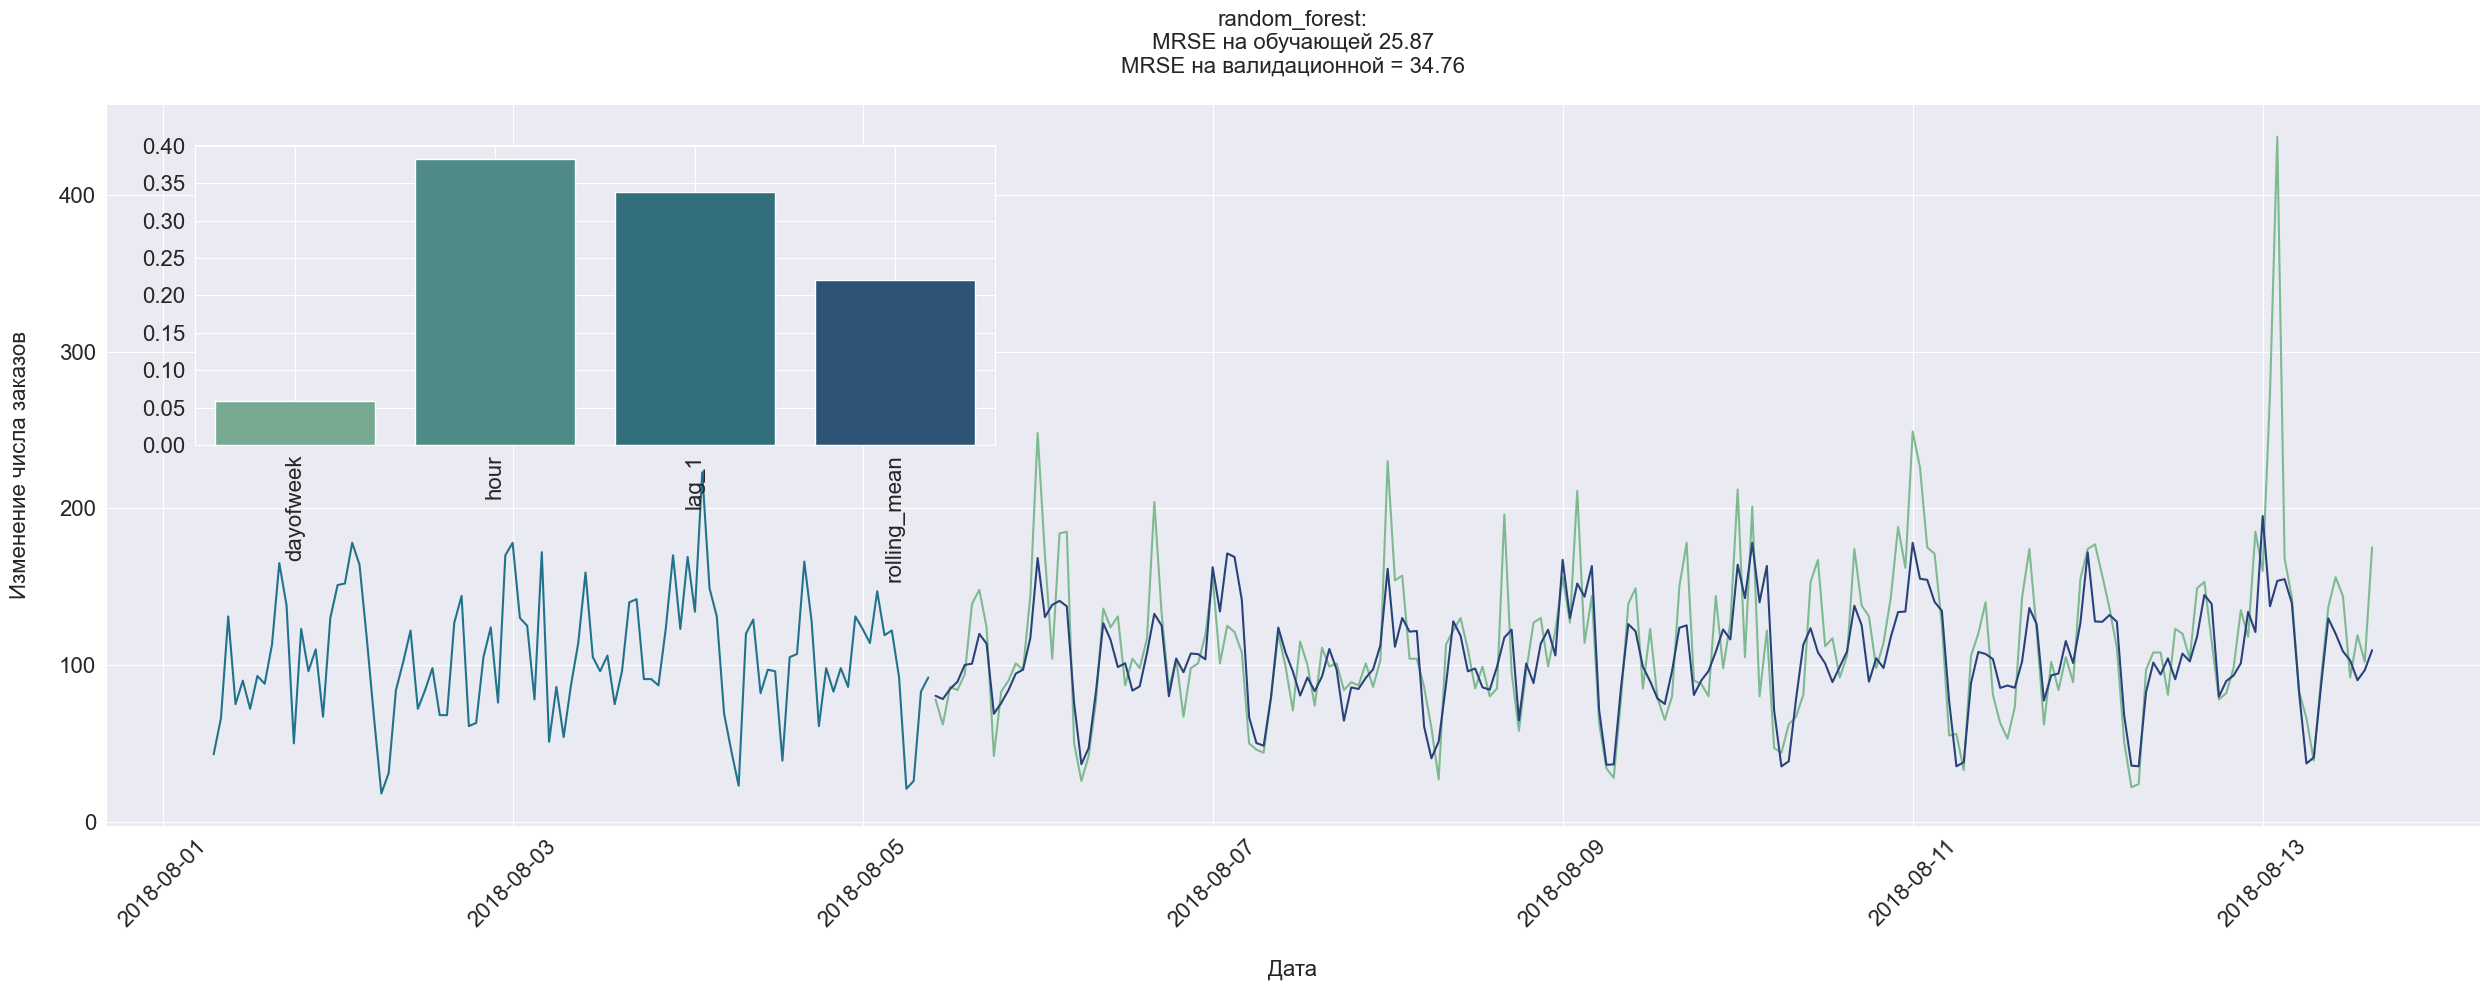

In [43]:
model_type = 'random_forest'
best_params[model_type], MRSEs[model_type], valid_MRSEs[model_type] = model_visualization(model_type=model_type, n_trials=10)

Лучше чем дерево. Важные признаки те же.

Повторим для xg_boost. 

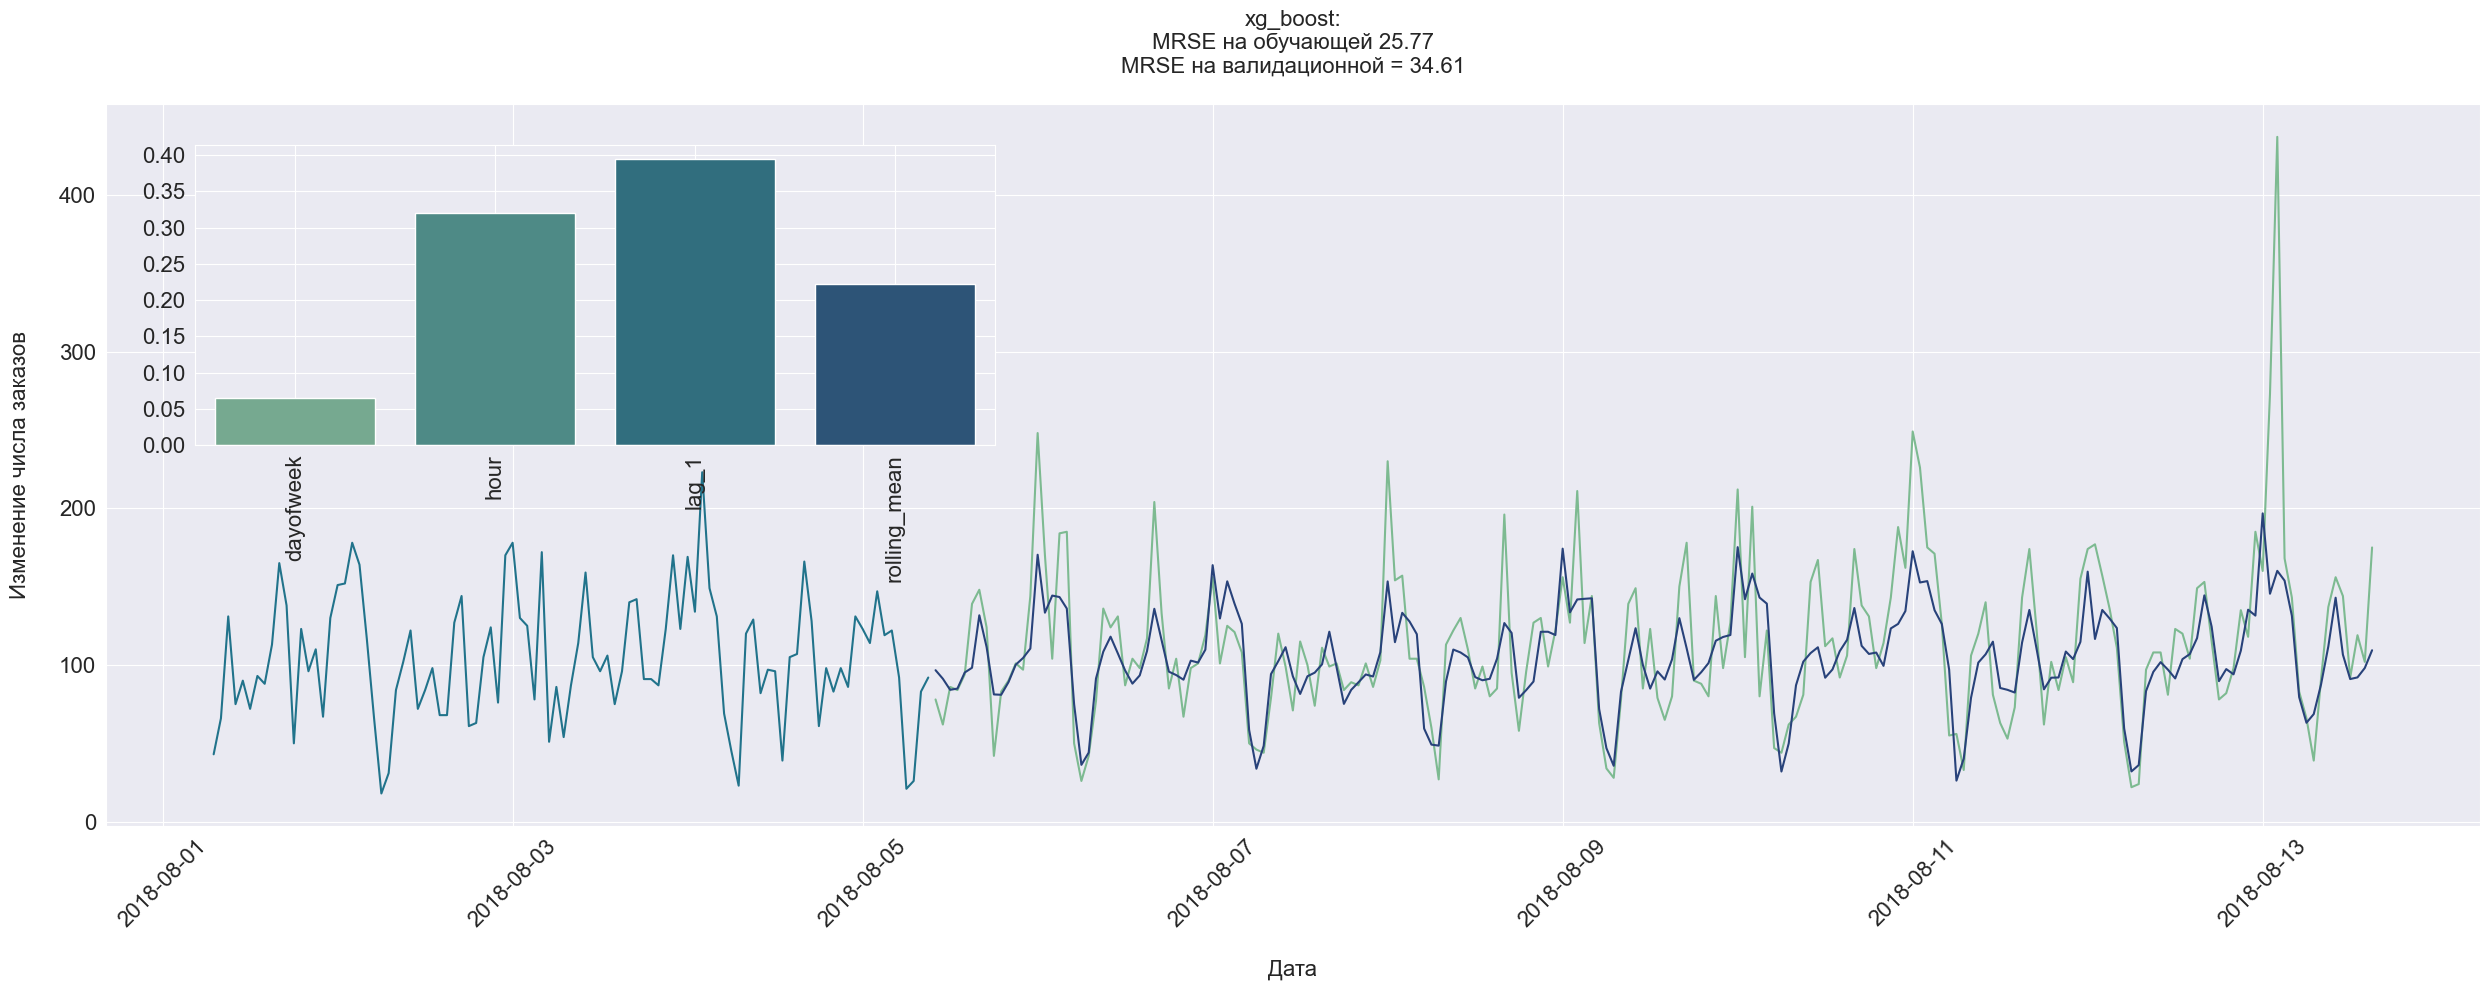

In [44]:
model_type = 'xg_boost'
best_params[model_type], MRSEs[model_type], valid_MRSEs[model_type] = model_visualization(model_type=model_type, n_trials=30)

Немного лучше леса. Снова самые важные признаки `hour` и `lag_1` 

Повторим для `light_GBM`. 

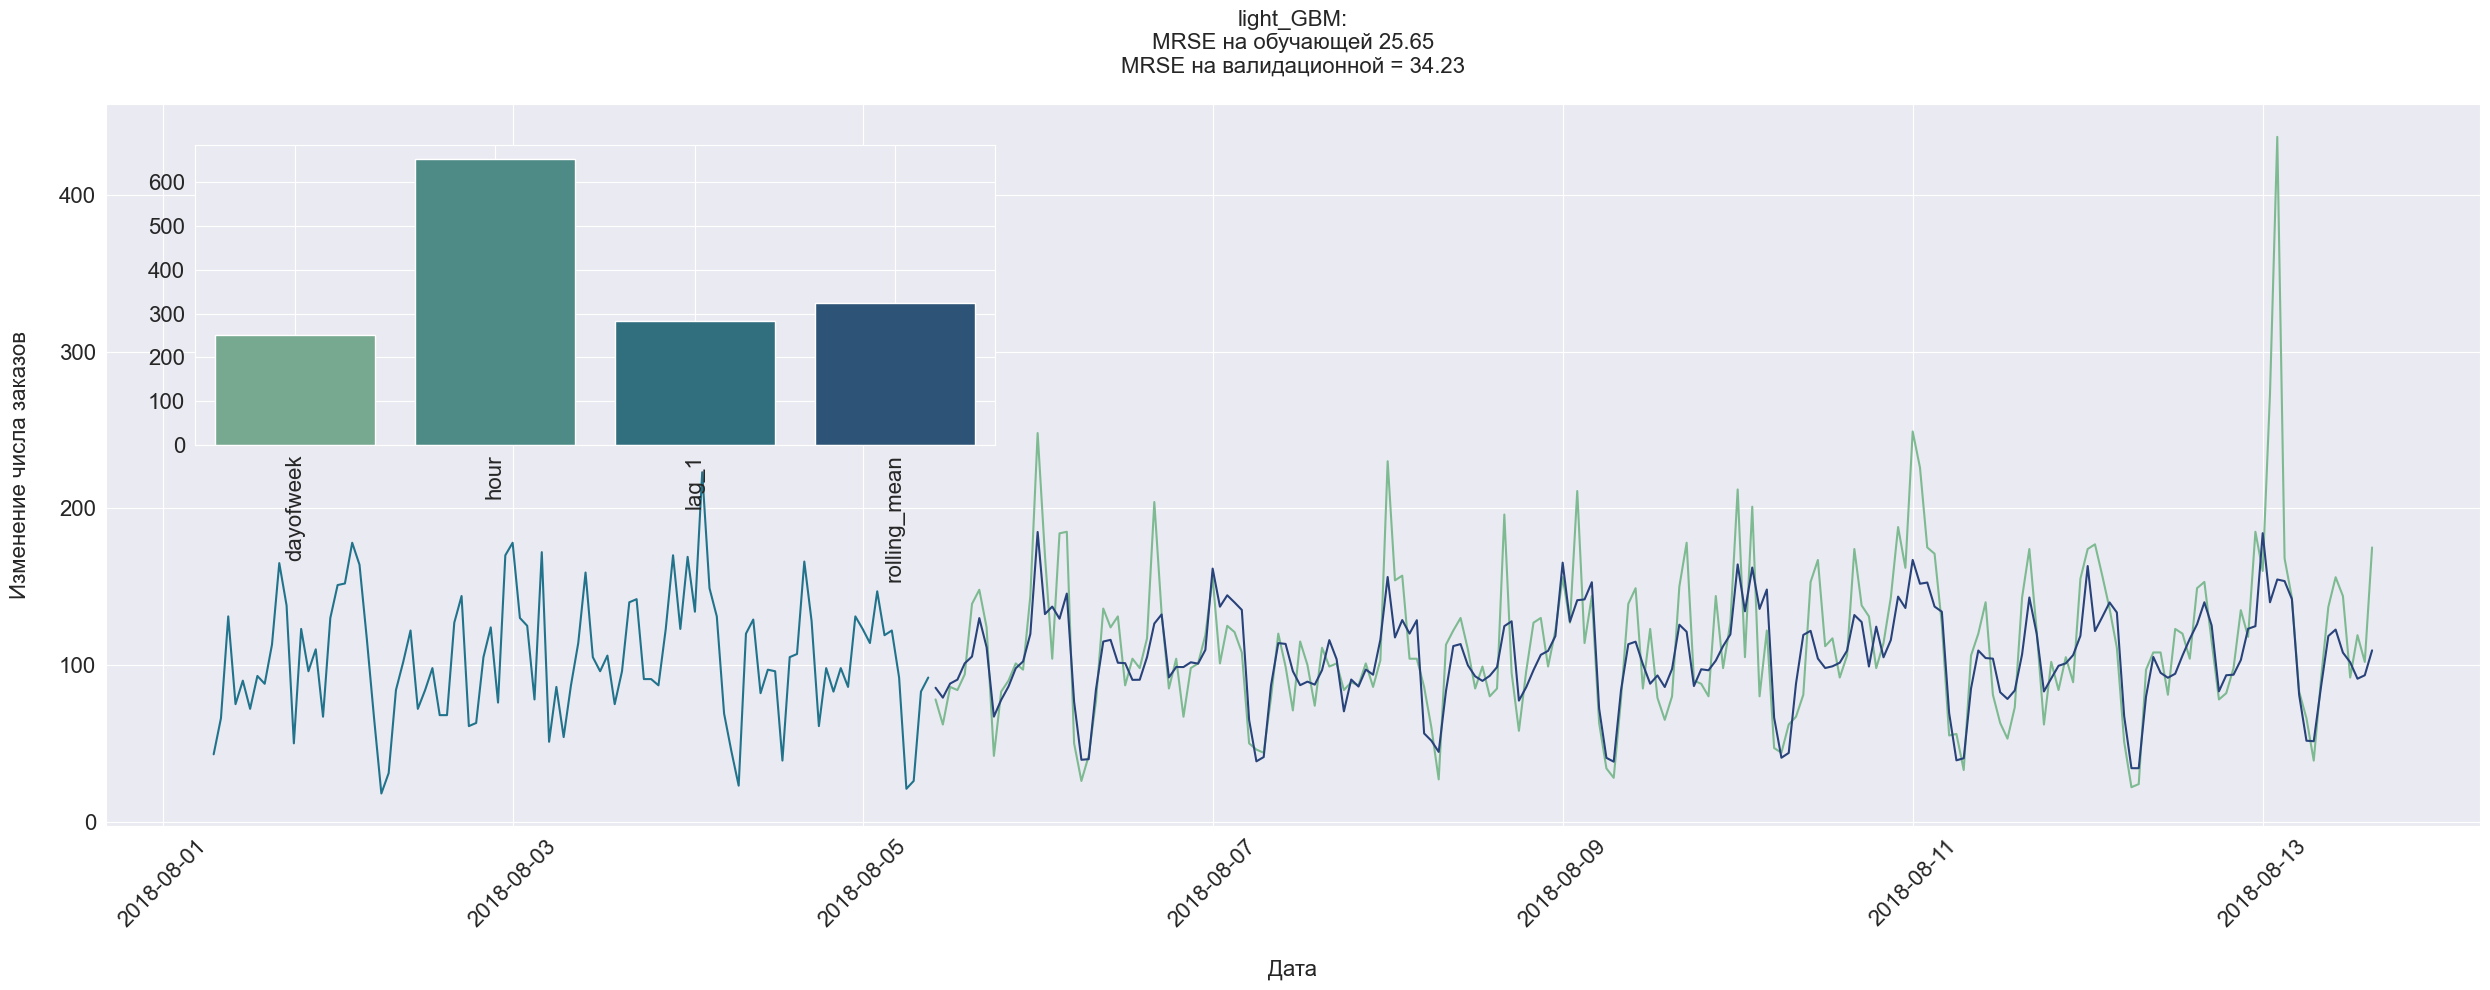

In [45]:
model_type = 'light_GBM'
best_params[model_type], MRSEs[model_type], valid_MRSEs[model_type] = model_visualization(model_type=model_type, n_trials=30)

Более однородно распределена важность. Минимумы заказов предсказываются хорошо, максимумы немного не дотягивают.

Резюмируем.

In [46]:
models = ['line', 'tree', 'random_forest', 'xg_boost', 'light_GBM']

In [47]:
data_metrics = pd.DataFrame({'MRSE': [MRSEs[i] for i in models],
                             'valid MRSE': [valid_MRSEs[i] for i in models],                            
                           })
data_metrics.index=models
data_metrics.style.background_gradient(cmap=cm)

,MRSE,valid MRSE
line,31.691174,44.753557
tree,28.221613,38.131598
random_forest,25.866187,34.757443
xg_boost,25.774345,34.606037
light_GBM,25.647787,34.234192


Лучшей моделью оказалась модель `light_GBM`

In [48]:
best_model = 'light_GBM'

### Вывод этапа

Рассмотрены модели:
- `LinearRegression`
- `DecisionTreeRegressor`
- `RandomForestRegressor`
- `XGBRegressor`
- `LGBMRegressor`

В качестве лучшей модели выбрана `LGBMRegressor`

<div class="alert alert-block alert-success">
<b>Успех:</b> Отличная работа с моделями. Визуализация была очень уместной.
</div>

## Тестирование

Дополним обучающую выборку валидационной.

In [49]:
X_train = pd.concat([X_train, X_valid])
Y_train = pd.concat([Y_train, Y_valid])

In [50]:
print(X_train.shape)

(3952, 4)


In [51]:
if best_model == 'line':
     model = LinearRegression(**best_params[best_model], random_state=RANDOM_STATE)
elif best_model == 'tree':
    model = DecisionTreeRegressor(**best_params[best_model], random_state=RANDOM_STATE)
elif best_model == 'random_forest':
        model = RandomForestRegressor(**best_params[best_model], random_state=RANDOM_STATE)
elif best_model == 'xg_boost':
        model = xgb.XGBRegressor(**best_params[best_model], random_state=RANDOM_STATE)
elif best_model == 'light_GBM':
        model = LGBMRegressor(**best_params[best_model], random_state=RANDOM_STATE, verbose=0)
    
model.fit(X_train, Y_train)
Y_pred = model.predict(X_test)
print(f'MRSE на тестовой выборке : {mean_squared_error(Y_pred,Y_test) ** .5}')

MRSE на тестовой выборке : 43.8083509408122


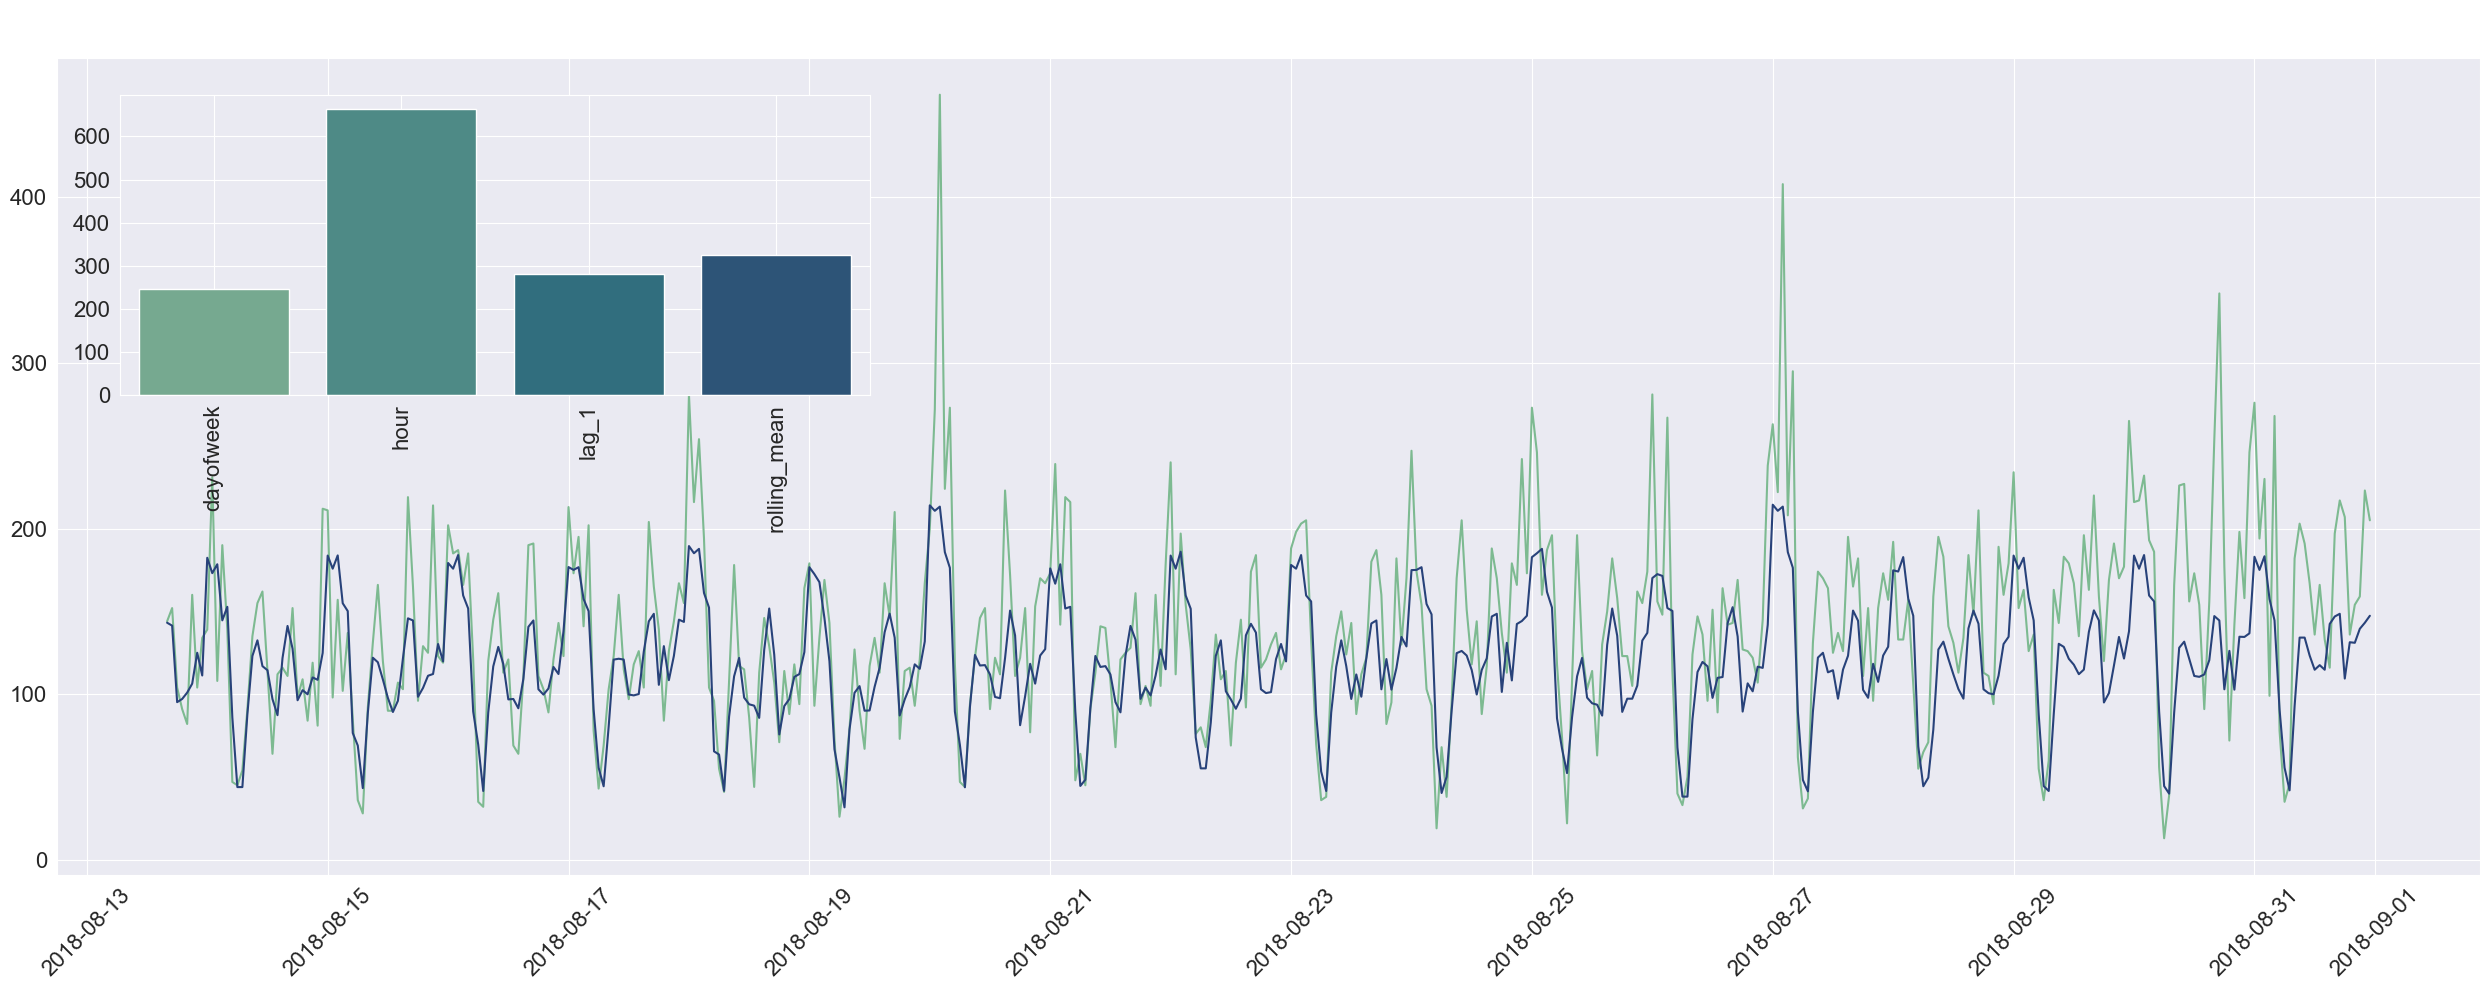

In [52]:
plt.figure(figsize=figsize(5,2))
Y_pred = pd.DataFrame(Y_pred,index=Y_test.index)
ax = plt.plot(Y_test,color=new_color(2))
plt.plot(Y_pred,color=new_color(18))
plot_set(ax)

plt.axes([.05, .6, .3, .3]) 
feature_importances = pd.DataFrame(model.feature_importances_,index = X_train.columns, columns = ['feature'])
ax1 = sns.barplot(data=feature_importances, x=feature_importances.index, y='feature', palette=cm)
plot_set(ax1,xrot=2)
plt.tight_layout()

## Вывод этапа

MRSE на тестовой выборке : 43.8

<div class="alert alert-block alert-success">
<b>Успех:</b> Выбранная модель показала неплохое качество на тестовой выборке

## Вывод

- Изучен датафрейм `taxi.csv`:
    - 1 столбец:
        - `num_orders` - число заказов за 10 минут
    - 26496 строк
    - Пропусков нет:
    - Данные отсортированы по времени от 00:00 01.03.2018 до 23:50 31.08.2018
- Тренд в общем растет, то есть количество заказов и пользователей растет.
- Распределение не однородно в течение дня.
- Временной ряд в не является стационарным, так как подвержен тренду, который меняется во времени.
- Рассмотрены модели:
    - `LinearRegression`
    - `DecisionTreeRegressor`
    - `RandomForestRegressor`
    - `XGBRegressor`
    - `LGBMRegressor`
- В качестве лучшей модели выбрана `LGBMRegressor`
- MRSE на тестовой выборке : 43.8

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Данные проанализированы
- [x]  Модель обучена, гиперпараметры подобраны
- [x]  Качество моделей проверено, выводы сделаны
- [x]  Значение *RMSE* на тестовой выборке не больше 48